In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR


## create DFM model BMI object

In [6]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM


## intitialize DFM model first to expose 1d coords

In [18]:
# initialize DFM to expose model coordinates via BMI
DFM_bmi.initialize()

INFO: model_functions_v2.write_config(): Ini file for DFM written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM/DFM_Elbe_VU.mdu
2018-03-29 09:16:47,866 coupling_PCR_FM.model_functions_v2 INFO Ini file for DFM written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM/DFM_Elbe_VU.mdu
INFO: wrapper.initialize(): Loading model /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM/DFM_Elbe_VU.mdu in directory /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM
2018-03-29 09:16:47,870 bmi.wrapper INFO Loading model /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM/DFM_Elbe_VU.mdu in directory /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM
INFO: model_functions_v2.initialize(): DFM initialized
2018-03-29 09:16:48,154 coupling_PCR_FM.model_functions_v2 INFO DFM initialized


## set coupling between PCR and DFM

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

INFO: model_functions_v2.couple_grid_to_1d(): Coupling PCR grid to DFM 1D nodes.
2018-03-29 09:16:50,830 coupling_PCR_FM.model_functions_v2 INFO Coupling PCR grid to DFM 1D nodes.
INFO: model_functions_v2.model_2d_index(): Getting PCR model indices of xy coordinates.
2018-03-29 09:16:50,831 coupling_PCR_FM.model_functions_v2 INFO Getting PCR model indices of xy coordinates.
2018-03-29 09:16:50,835 coupling_PCR_FM.model_functions_v2 WARNING 1D nodes found outside of valid 2D domain
INFO: model_functions_v2.couple_grid_to_1d(): Getting fraction of coupled 1d nodes based on area.
2018-03-29 09:16:50,837 coupling_PCR_FM.model_functions_v2 INFO Getting fraction of coupled 1d nodes based on area.
INFO: model_functions_v2.get_coupled_grid_mask(): Creating mask for coupled PCR cells.
2018-03-29 09:16:50,839 coupling_PCR_FM.model_functions_v2 INFO Creating mask for coupled PCR cells.


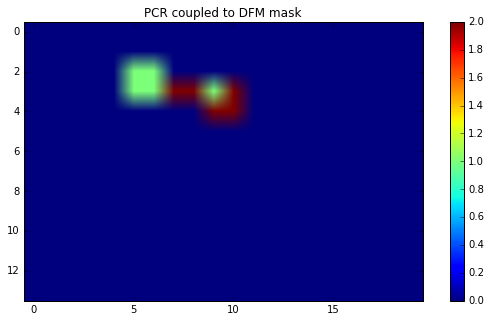

In [19]:
# get coupled dictionaries
PCR_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(PCR_bmi.coupled_mask, vmin=0, vmax=2, interpolation=None)
plt.colorbar()
b.set_title('PCR coupled to DFM mask')

In [20]:
# initialize PCR to after editing ldd grid
PCR_bmi.initialize()

INFO: model_functions_v2.write_config(): Ini file for PCR written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR/setup_PCR_30min_Elbe.ini
2018-03-29 09:16:52,012 coupling_PCR_FM.model_functions_v2 INFO Ini file for PCR written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR/setup_PCR_30min_Elbe.ini
INFO: configuration.initialize_logging(): Model run started at 2018-03-29 09:16:52.014165
2018-03-29 09:16:52,019 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-29 09:16:52.014165
2018-03-29 09:16:52,019 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-29 09:16:52.014165
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-29T09:16:52.014165.log
2018-03-29 09:16:52,020 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_20

## run coupled PCR - DFM model

In [21]:
# run coupled model for 2 timesteps
def get_PCR_delta_vol():
    # coupled 2d mask
    mask = PCR_bmi.coupled_mask > 0
    # Q outflow 2D for coupled cells
    # NOTE: see if we can change this for cell inflow, like with the get_CMF_delta_vol
    q_out = np.where(mask, PCR_bmi.get_var('discharge'), 0) # [m3/s]
    q_out = q_out * 86400.
    # PCR runoff inflow 2D for coupled cells
    runoff = np.where(mask, PCR_bmi.get_var('runoff') * PCR_bmi.get_var('cellArea'), 0) # [m3/day]
    # take discharge in most upstream coupled cells, runoff for other cells
    tot_flux = np.where(PCR_bmi.coupled_mask == 2, q_out, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux #* PCR_bmi.options['dt'] # [m3/day]
    return delta_vol 


DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
PCRidx = PCR_bmi.coupled_idx
PCRfrac = PCR_bmi.coupled_area_frac

def set_DFM_forcing():
    PCR_delta_vol = get_PCR_delta_vol() # 2d array [m3/day]
    print np.sum(PCR_delta_vol)
    DFM_depth_conservative = PCR_delta_vol[PCRidx] * PCRfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return PCR_delta_vol

In [22]:
tStart = datetime.now()
# for i in range(timeSteps):
for i in range(365):
    PCR_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()  

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-29 09:19:12,707 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-03-29 09:19:12,707 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-29 09:19:12,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-03-29 09:19:12,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-29 09:19:14,628 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-29 09:19:14,628 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1


4.92852e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-29 09:19:14,979 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-29 09:19:14,979 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-29 09:19:14,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
2018-03-29 09:19:14,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO: pcrglobwb.update(): updating model to time 2000-01-02
2018-03-29 09:19:15,267 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
2018-03-29 09:19:15,267 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-03-29 09:19:16,151 coupling_PCR_FM.mo

6.68993e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
2018-03-29 09:19:16,612 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
2018-03-29 09:19:16,612 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-03
2018-03-29 09:19:16,615 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-03
2018-03-29 09:19:16,615 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-03
INFO: pcrglobwb.update(): updating model to time 2000-01-03
2018-03-29 09:19:16,892 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03
2018-03-29 09:19:16,892 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3
2018-03-29 09:19:17,765 coupling_PCR_FM

7.90122e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
2018-03-29 09:19:18,235 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
2018-03-29 09:19:18,235 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-04
2018-03-29 09:19:18,238 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-04
2018-03-29 09:19:18,238 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-04
INFO: pcrglobwb.update(): updating model to time 2000-01-04
2018-03-29 09:19:18,518 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-04
2018-03-29 09:19:18,518 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4
2018-03-29 09:19:19,372 coupling_PCR_FM

8.1725e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
2018-03-29 09:19:19,876 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
2018-03-29 09:19:19,876 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-05
2018-03-29 09:19:19,879 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-05
2018-03-29 09:19:19,879 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-05
INFO: pcrglobwb.update(): updating model to time 2000-01-05
2018-03-29 09:19:20,164 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-05
2018-03-29 09:19:20,164 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5
2018-03-29 09:19:21,014 coupling_PCR_FM

8.03522e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 432000.0, timestep 86400.0
2018-03-29 09:19:21,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 432000.0, timestep 86400.0
2018-03-29 09:19:21,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 432000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-06
2018-03-29 09:19:21,560 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-06
2018-03-29 09:19:21,560 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-06
INFO: pcrglobwb.update(): updating model to time 2000-01-06
2018-03-29 09:19:21,828 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-06
2018-03-29 09:19:21,828 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6
2018-03-29 09:19:22,663 coupling_PCR_FM

7.66584e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
2018-03-29 09:19:23,184 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
2018-03-29 09:19:23,184 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-07
2018-03-29 09:19:23,187 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-07
2018-03-29 09:19:23,187 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-07
INFO: pcrglobwb.update(): updating model to time 2000-01-07
2018-03-29 09:19:23,465 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-07
2018-03-29 09:19:23,465 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7
2018-03-29 09:19:24,344 coupling_PCR_FM

7.24857e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
2018-03-29 09:19:24,913 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
2018-03-29 09:19:24,913 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-08
2018-03-29 09:19:24,915 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-08
2018-03-29 09:19:24,915 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-08
INFO: pcrglobwb.update(): updating model to time 2000-01-08
2018-03-29 09:19:25,194 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-08
2018-03-29 09:19:25,194 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8
2018-03-29 09:19:26,029 coupling_PCR_FM

6.84266e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-29 09:19:26,557 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-29 09:19:26,557 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-03-29 09:19:26,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
2018-03-29 09:19:26,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-29 09:19:26,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
2018-03-29 09:19:26,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-29 09:19:27,668 coupling_PCR_FM

6.53762e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
2018-03-29 09:19:28,213 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
2018-03-29 09:19:28,213 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-10
2018-03-29 09:19:28,215 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-10
2018-03-29 09:19:28,215 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-10
INFO: pcrglobwb.update(): updating model to time 2000-01-10
2018-03-29 09:19:28,493 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-10
2018-03-29 09:19:28,493 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10
2018-03-29 09:19:29,375 coupling_PCR_F

6.54734e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
2018-03-29 09:19:29,898 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
2018-03-29 09:19:29,898 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-03-29 09:19:29,900 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
2018-03-29 09:19:29,900 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-03-29 09:19:30,176 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
2018-03-29 09:19:30,176 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-29 09:19:31,031 coupling_PCR_F

6.80477e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
2018-03-29 09:19:31,644 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
2018-03-29 09:19:31,644 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-29 09:19:31,646 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
2018-03-29 09:19:31,646 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
INFO: pcrglobwb.update(): updating model to time 2000-01-12
2018-03-29 09:19:31,923 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12
2018-03-29 09:19:31,923 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
2018-03-29 09:19:32,779 coupling_PCR_F

6.83171e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
2018-03-29 09:19:33,335 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
2018-03-29 09:19:33,335 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-13
2018-03-29 09:19:33,338 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-13
2018-03-29 09:19:33,338 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-13
INFO: pcrglobwb.update(): updating model to time 2000-01-13
2018-03-29 09:19:33,617 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-13
2018-03-29 09:19:33,617 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13
2018-03-29 09:19:34,459 coupling_PC

6.34332e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1123200.0, timestep 86400.0
2018-03-29 09:19:35,056 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1123200.0, timestep 86400.0
2018-03-29 09:19:35,056 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1123200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-14
2018-03-29 09:19:35,058 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-14
2018-03-29 09:19:35,058 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-14
INFO: pcrglobwb.update(): updating model to time 2000-01-14
2018-03-29 09:19:35,336 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-14
2018-03-29 09:19:35,336 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14
2018-03-29 09:19:36,194 coupling_PC

5.67312e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
2018-03-29 09:19:36,743 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
2018-03-29 09:19:36,743 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-15
2018-03-29 09:19:36,746 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-15
2018-03-29 09:19:36,746 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-15
INFO: pcrglobwb.update(): updating model to time 2000-01-15
2018-03-29 09:19:37,030 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-15
2018-03-29 09:19:37,030 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15
2018-03-29 09:19:37,866 coupling_PC

5.16273e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
2018-03-29 09:19:38,376 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
2018-03-29 09:19:38,376 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-16
2018-03-29 09:19:38,378 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-16
2018-03-29 09:19:38,378 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-16
INFO: pcrglobwb.update(): updating model to time 2000-01-16
2018-03-29 09:19:38,648 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-16
2018-03-29 09:19:38,648 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16
2018-03-29 09:19:39,482 coupling_PC

4.85574e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-29 09:19:40,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-29 09:19:40,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-29 09:19:40,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
2018-03-29 09:19:40,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-29 09:19:40,285 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
2018-03-29 09:19:40,285 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-29 09:19:41,152 coupling_PC

4.68082e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1468800.0, timestep 86400.0
2018-03-29 09:19:41,645 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1468800.0, timestep 86400.0
2018-03-29 09:19:41,645 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1468800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-18
2018-03-29 09:19:41,647 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-18
2018-03-29 09:19:41,647 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-18
INFO: pcrglobwb.update(): updating model to time 2000-01-18
2018-03-29 09:19:41,930 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18
2018-03-29 09:19:41,930 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
2018-03-29 09:19:42,800 coupling_PC

4.6158e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
2018-03-29 09:19:43,320 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
2018-03-29 09:19:43,320 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-19
2018-03-29 09:19:43,322 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19
2018-03-29 09:19:43,322 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19
INFO: pcrglobwb.update(): updating model to time 2000-01-19
2018-03-29 09:19:43,600 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19
2018-03-29 09:19:43,600 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19
2018-03-29 09:19:44,456 coupling_PC

4.60621e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
2018-03-29 09:19:44,993 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
2018-03-29 09:19:44,993 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-20
2018-03-29 09:19:44,995 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-20
2018-03-29 09:19:44,995 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-20
INFO: pcrglobwb.update(): updating model to time 2000-01-20
2018-03-29 09:19:45,255 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-20
2018-03-29 09:19:45,255 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20
2018-03-29 09:19:46,100 coupling_PC

4.54838e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1728000.0, timestep 86400.0
2018-03-29 09:19:46,611 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1728000.0, timestep 86400.0
2018-03-29 09:19:46,611 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1728000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-21
2018-03-29 09:19:46,613 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
2018-03-29 09:19:46,613 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
INFO: pcrglobwb.update(): updating model to time 2000-01-21
2018-03-29 09:19:46,893 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
2018-03-29 09:19:46,893 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-29 09:19:47,753 coupling_PC

4.52735e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
2018-03-29 09:19:48,243 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
2018-03-29 09:19:48,243 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-22
2018-03-29 09:19:48,245 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
2018-03-29 09:19:48,245 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
INFO: pcrglobwb.update(): updating model to time 2000-01-22
2018-03-29 09:19:48,525 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-22
2018-03-29 09:19:48,525 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22
2018-03-29 09:19:49,401 coupling_PC

4.54714e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
2018-03-29 09:19:49,901 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
2018-03-29 09:19:49,901 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-23
2018-03-29 09:19:49,903 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-23
2018-03-29 09:19:49,903 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-23
INFO: pcrglobwb.update(): updating model to time 2000-01-23
2018-03-29 09:19:50,183 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-23
2018-03-29 09:19:50,183 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-23, timestep 23
2018-03-29 09:19:51,054 coupling_PC

4.52069e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
2018-03-29 09:19:51,547 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
2018-03-29 09:19:51,547 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-24
2018-03-29 09:19:51,550 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-24
2018-03-29 09:19:51,550 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-24
INFO: pcrglobwb.update(): updating model to time 2000-01-24
2018-03-29 09:19:51,827 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-24
2018-03-29 09:19:51,827 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-29 09:19:52,667 coupling_PC

4.38291e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-29 09:19:53,197 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-29 09:19:53,197 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-03-29 09:19:53,199 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
2018-03-29 09:19:53,199 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-29 09:19:53,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-25
2018-03-29 09:19:53,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-25, timestep 25
2018-03-29 09:19:54,301 coupling_PC

4.0077e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
2018-03-29 09:19:54,788 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
2018-03-29 09:19:54,788 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-26
2018-03-29 09:19:54,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-26
2018-03-29 09:19:54,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-26
INFO: pcrglobwb.update(): updating model to time 2000-01-26
2018-03-29 09:19:55,058 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-26
2018-03-29 09:19:55,058 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-26, timestep 26
2018-03-29 09:19:55,900 coupling_PC

3.55835e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
2018-03-29 09:19:56,375 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
2018-03-29 09:19:56,375 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-27
2018-03-29 09:19:56,378 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-27
2018-03-29 09:19:56,378 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-27
INFO: pcrglobwb.update(): updating model to time 2000-01-27
2018-03-29 09:19:56,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-27
2018-03-29 09:19:56,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-27, timestep 27
2018-03-29 09:19:57,490 coupling_PC

3.236e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
2018-03-29 09:19:57,966 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
2018-03-29 09:19:57,966 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-28
2018-03-29 09:19:57,968 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-28
2018-03-29 09:19:57,968 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-28
INFO: pcrglobwb.update(): updating model to time 2000-01-28
2018-03-29 09:19:58,238 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-28
2018-03-29 09:19:58,238 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-28, timestep 28
2018-03-29 09:19:59,093 coupling_PC

3.0626e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
2018-03-29 09:19:59,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
2018-03-29 09:19:59,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-29
2018-03-29 09:19:59,560 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-29
2018-03-29 09:19:59,560 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-29
INFO: pcrglobwb.update(): updating model to time 2000-01-29
2018-03-29 09:19:59,834 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-29
2018-03-29 09:19:59,834 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-29, timestep 29
2018-03-29 09:20:00,683 coupling_PC

3.1541e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
2018-03-29 09:20:01,149 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
2018-03-29 09:20:01,149 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-30
2018-03-29 09:20:01,155 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-30
2018-03-29 09:20:01,155 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-30
INFO: pcrglobwb.update(): updating model to time 2000-01-30
2018-03-29 09:20:01,437 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-30
2018-03-29 09:20:01,437 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-30, timestep 30
2018-03-29 09:20:02,272 coupling_PC

3.67828e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2592000.0, timestep 86400.0
2018-03-29 09:20:02,730 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2592000.0, timestep 86400.0
2018-03-29 09:20:02,730 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2592000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-31
2018-03-29 09:20:02,737 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
2018-03-29 09:20:02,737 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
INFO: pcrglobwb.update(): updating model to time 2000-01-31
2018-03-29 09:20:03,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
2018-03-29 09:20:03,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-29 09:20:03,855 coupling_PC

4.18026e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
2018-03-29 09:20:04,339 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
2018-03-29 09:20:04,339 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-01
2018-03-29 09:20:04,342 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
2018-03-29 09:20:04,342 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-29 09:20:04,621 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
2018-03-29 09:20:04,621 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-29 09:20:05,718 coupling_PC

4.42945e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-29 09:20:06,227 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-29 09:20:06,227 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-02
2018-03-29 09:20:06,229 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-02
2018-03-29 09:20:06,229 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-02
INFO: pcrglobwb.update(): updating model to time 2000-02-02
2018-03-29 09:20:06,510 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-02
2018-03-29 09:20:06,510 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33
2018-03-29 09:20:07,363 coupling_PC

4.54041e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
2018-03-29 09:20:07,847 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
2018-03-29 09:20:07,847 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-03
2018-03-29 09:20:07,849 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-03
2018-03-29 09:20:07,849 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-03
INFO: pcrglobwb.update(): updating model to time 2000-02-03
2018-03-29 09:20:08,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-03
2018-03-29 09:20:08,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-03, timestep 34
2018-03-29 09:20:08,981 coupling_PC

4.51206e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
2018-03-29 09:20:09,493 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
2018-03-29 09:20:09,493 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-04
2018-03-29 09:20:09,495 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-04
2018-03-29 09:20:09,495 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-04
INFO: pcrglobwb.update(): updating model to time 2000-02-04
2018-03-29 09:20:09,774 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-04
2018-03-29 09:20:09,774 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-04, timestep 35
2018-03-29 09:20:10,628 coupling_PC

4.27517e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
2018-03-29 09:20:11,186 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
2018-03-29 09:20:11,186 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-05
2018-03-29 09:20:11,189 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-05
2018-03-29 09:20:11,189 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-05
INFO: pcrglobwb.update(): updating model to time 2000-02-05
2018-03-29 09:20:11,457 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-05
2018-03-29 09:20:11,457 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-05, timestep 36
2018-03-29 09:20:12,324 coupling_PC

4.04863e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3110400.0, timestep 86400.0
2018-03-29 09:20:12,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3110400.0, timestep 86400.0
2018-03-29 09:20:12,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3110400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-06
2018-03-29 09:20:12,810 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-06
2018-03-29 09:20:12,810 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-06
INFO: pcrglobwb.update(): updating model to time 2000-02-06
2018-03-29 09:20:13,092 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-06
2018-03-29 09:20:13,092 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-06, timestep 37
2018-03-29 09:20:13,931 coupling_PC

3.78083e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
2018-03-29 09:20:14,405 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
2018-03-29 09:20:14,405 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-07
2018-03-29 09:20:14,407 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-07
2018-03-29 09:20:14,407 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-07
INFO: pcrglobwb.update(): updating model to time 2000-02-07
2018-03-29 09:20:14,683 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-07
2018-03-29 09:20:14,683 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-07, timestep 38
2018-03-29 09:20:15,535 coupling_PC

3.5578e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
2018-03-29 09:20:16,009 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
2018-03-29 09:20:16,009 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-08
2018-03-29 09:20:16,011 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-08
2018-03-29 09:20:16,011 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-08
INFO: pcrglobwb.update(): updating model to time 2000-02-08
2018-03-29 09:20:16,279 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-08
2018-03-29 09:20:16,279 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-08, timestep 39
2018-03-29 09:20:17,130 coupling_PC

3.54553e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-29 09:20:17,614 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-29 09:20:17,614 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-29 09:20:17,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
2018-03-29 09:20:17,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-29 09:20:17,884 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
2018-03-29 09:20:17,884 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-29 09:20:18,740 coupling_PC

3.79995e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
2018-03-29 09:20:19,231 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
2018-03-29 09:20:19,231 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-10
2018-03-29 09:20:19,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
2018-03-29 09:20:19,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
INFO: pcrglobwb.update(): updating model to time 2000-02-10
2018-03-29 09:20:19,519 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
2018-03-29 09:20:19,519 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-29 09:20:20,382 coupling_PC

3.92545e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
2018-03-29 09:20:20,881 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
2018-03-29 09:20:20,881 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-11
2018-03-29 09:20:20,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
2018-03-29 09:20:20,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
INFO: pcrglobwb.update(): updating model to time 2000-02-11
2018-03-29 09:20:21,167 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-11
2018-03-29 09:20:21,167 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-11, timestep 42
2018-03-29 09:20:22,019 coupling_PC

3.80656e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
2018-03-29 09:20:22,503 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
2018-03-29 09:20:22,503 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-12
2018-03-29 09:20:22,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-12
2018-03-29 09:20:22,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-12
INFO: pcrglobwb.update(): updating model to time 2000-02-12
2018-03-29 09:20:22,786 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-12
2018-03-29 09:20:22,786 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43
2018-03-29 09:20:23,643 coupling_PC

3.51291e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
2018-03-29 09:20:24,106 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
2018-03-29 09:20:24,106 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-13
2018-03-29 09:20:24,108 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-13
2018-03-29 09:20:24,108 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-13
INFO: pcrglobwb.update(): updating model to time 2000-02-13
2018-03-29 09:20:24,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-13
2018-03-29 09:20:24,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-13, timestep 44
2018-03-29 09:20:25,233 coupling_PC

3.23674e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3801600.0, timestep 86400.0
2018-03-29 09:20:25,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3801600.0, timestep 86400.0
2018-03-29 09:20:25,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3801600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-14
2018-03-29 09:20:25,721 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-14
2018-03-29 09:20:25,721 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-14
INFO: pcrglobwb.update(): updating model to time 2000-02-14
2018-03-29 09:20:26,002 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-14
2018-03-29 09:20:26,002 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-14, timestep 45
2018-03-29 09:20:26,860 coupling_PC

3.1133e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
2018-03-29 09:20:27,382 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
2018-03-29 09:20:27,382 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-15
2018-03-29 09:20:27,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-15
2018-03-29 09:20:27,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-15
INFO: pcrglobwb.update(): updating model to time 2000-02-15
2018-03-29 09:20:27,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-15
2018-03-29 09:20:27,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-15, timestep 46
2018-03-29 09:20:28,517 coupling_PC

3.02531e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
2018-03-29 09:20:28,973 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
2018-03-29 09:20:28,973 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-16
2018-03-29 09:20:28,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-16
2018-03-29 09:20:28,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-16
INFO: pcrglobwb.update(): updating model to time 2000-02-16
2018-03-29 09:20:29,248 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-16
2018-03-29 09:20:29,248 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-16, timestep 47
2018-03-29 09:20:30,096 coupling_PC

3.04799e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-29 09:20:30,593 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-29 09:20:30,593 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-29 09:20:30,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
2018-03-29 09:20:30,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-29 09:20:30,867 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
2018-03-29 09:20:30,867 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-29 09:20:31,729 coupling_PC

3.15885e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
2018-03-29 09:20:32,176 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
2018-03-29 09:20:32,176 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-18
2018-03-29 09:20:32,179 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-18
2018-03-29 09:20:32,179 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-18
INFO: pcrglobwb.update(): updating model to time 2000-02-18
2018-03-29 09:20:32,451 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-18
2018-03-29 09:20:32,451 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-18, timestep 49
2018-03-29 09:20:33,304 coupling_PC

3.11982e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4233600.0, timestep 86400.0
2018-03-29 09:20:33,757 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4233600.0, timestep 86400.0
2018-03-29 09:20:33,757 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-19
2018-03-29 09:20:33,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-19
2018-03-29 09:20:33,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-19
INFO: pcrglobwb.update(): updating model to time 2000-02-19
2018-03-29 09:20:34,043 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-19
2018-03-29 09:20:34,043 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50
2018-03-29 09:20:34,884 coupling_PC

3.06949e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
2018-03-29 09:20:35,378 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
2018-03-29 09:20:35,378 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-20
2018-03-29 09:20:35,380 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
2018-03-29 09:20:35,380 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
INFO: pcrglobwb.update(): updating model to time 2000-02-20
2018-03-29 09:20:35,654 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
2018-03-29 09:20:35,654 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-03-29 09:20:36,491 coupling_PC

3.0732e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4406400.0, timestep 86400.0
2018-03-29 09:20:36,961 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4406400.0, timestep 86400.0
2018-03-29 09:20:36,961 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4406400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-21
2018-03-29 09:20:36,964 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
2018-03-29 09:20:36,964 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
INFO: pcrglobwb.update(): updating model to time 2000-02-21
2018-03-29 09:20:37,244 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-21
2018-03-29 09:20:37,244 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-21, timestep 52
2018-03-29 09:20:38,078 coupling_PC

3.04566e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
2018-03-29 09:20:38,543 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
2018-03-29 09:20:38,543 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-22
2018-03-29 09:20:38,545 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-22
2018-03-29 09:20:38,545 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-22
INFO: pcrglobwb.update(): updating model to time 2000-02-22
2018-03-29 09:20:38,827 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-22
2018-03-29 09:20:38,827 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-22, timestep 53
2018-03-29 09:20:39,691 coupling_PC

2.93631e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
2018-03-29 09:20:40,154 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
2018-03-29 09:20:40,154 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-23
2018-03-29 09:20:40,156 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-23
2018-03-29 09:20:40,156 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-23
INFO: pcrglobwb.update(): updating model to time 2000-02-23
2018-03-29 09:20:40,434 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-23
2018-03-29 09:20:40,434 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54
2018-03-29 09:20:41,285 coupling_PC

2.78854e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
2018-03-29 09:20:41,734 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
2018-03-29 09:20:41,734 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-24
2018-03-29 09:20:41,740 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-24
2018-03-29 09:20:41,740 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-24
INFO: pcrglobwb.update(): updating model to time 2000-02-24
2018-03-29 09:20:42,028 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-24
2018-03-29 09:20:42,028 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-29 09:20:42,880 coupling_PC

2.71835e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-29 09:20:43,343 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-29 09:20:43,343 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-03-29 09:20:43,349 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
2018-03-29 09:20:43,349 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-29 09:20:43,643 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-25
2018-03-29 09:20:43,643 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-25, timestep 56
2018-03-29 09:20:44,502 coupling_PC

2.8739e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
2018-03-29 09:20:44,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
2018-03-29 09:20:44,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-26
2018-03-29 09:20:44,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-26
2018-03-29 09:20:44,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-26
INFO: pcrglobwb.update(): updating model to time 2000-02-26
2018-03-29 09:20:45,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-26
2018-03-29 09:20:45,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-26, timestep 57
2018-03-29 09:20:46,075 coupling_PC

3.32429e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4924800.0, timestep 86400.0
2018-03-29 09:20:46,512 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4924800.0, timestep 86400.0
2018-03-29 09:20:46,512 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-27
2018-03-29 09:20:46,514 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-27
2018-03-29 09:20:46,514 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-27
INFO: pcrglobwb.update(): updating model to time 2000-02-27
2018-03-29 09:20:46,795 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-27
2018-03-29 09:20:46,795 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-27, timestep 58
2018-03-29 09:20:47,660 coupling_PC

3.60456e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
2018-03-29 09:20:48,135 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
2018-03-29 09:20:48,135 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-28
2018-03-29 09:20:48,137 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-28
2018-03-29 09:20:48,137 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-28
INFO: pcrglobwb.update(): updating model to time 2000-02-28
2018-03-29 09:20:48,416 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-28
2018-03-29 09:20:48,416 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-28, timestep 59
2018-03-29 09:20:49,281 coupling_PC

3.55249e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
2018-03-29 09:20:49,761 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
2018-03-29 09:20:49,761 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-29
2018-03-29 09:20:49,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-29
2018-03-29 09:20:49,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-29
INFO: pcrglobwb.update(): updating model to time 2000-02-29
2018-03-29 09:20:50,046 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-29
2018-03-29 09:20:50,046 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60
2018-03-29 09:20:50,905 coupling_PC

3.38448e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
2018-03-29 09:20:51,365 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
2018-03-29 09:20:51,365 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-01
2018-03-29 09:20:51,368 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
2018-03-29 09:20:51,368 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
INFO: pcrglobwb.update(): updating model to time 2000-03-01
2018-03-29 09:20:51,652 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
2018-03-29 09:20:51,652 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
2018-03-29 09:20:52,741 coupling_PC

3.21296e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5270400.0, timestep 86400.0
2018-03-29 09:20:53,203 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5270400.0, timestep 86400.0
2018-03-29 09:20:53,203 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5270400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-02
2018-03-29 09:20:53,210 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
2018-03-29 09:20:53,210 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
INFO: pcrglobwb.update(): updating model to time 2000-03-02
2018-03-29 09:20:53,485 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-02
2018-03-29 09:20:53,485 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-02, timestep 62
2018-03-29 09:20:54,338 coupling_PC

3.10182e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
2018-03-29 09:20:54,807 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
2018-03-29 09:20:54,807 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-03
2018-03-29 09:20:54,809 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
2018-03-29 09:20:54,809 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-29 09:20:55,076 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
2018-03-29 09:20:55,076 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-29 09:20:55,943 coupling_PC

3.06187e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-29 09:20:56,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-29 09:20:56,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-04
2018-03-29 09:20:56,387 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-04
2018-03-29 09:20:56,387 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-04
INFO: pcrglobwb.update(): updating model to time 2000-03-04
2018-03-29 09:20:56,661 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-04
2018-03-29 09:20:56,661 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64
2018-03-29 09:20:57,516 coupling_PC

3.0834e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
2018-03-29 09:20:57,990 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
2018-03-29 09:20:57,990 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-05
2018-03-29 09:20:57,993 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-05
2018-03-29 09:20:57,993 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-05
INFO: pcrglobwb.update(): updating model to time 2000-03-05
2018-03-29 09:20:58,270 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-05
2018-03-29 09:20:58,270 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-05, timestep 65
2018-03-29 09:20:59,149 coupling_PC

3.15597e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
2018-03-29 09:20:59,666 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
2018-03-29 09:20:59,666 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-06
2018-03-29 09:20:59,668 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-06
2018-03-29 09:20:59,668 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-06
INFO: pcrglobwb.update(): updating model to time 2000-03-06
2018-03-29 09:20:59,951 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-06
2018-03-29 09:20:59,951 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-06, timestep 66
2018-03-29 09:21:00,807 coupling_PC

3.22711e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
2018-03-29 09:21:01,248 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
2018-03-29 09:21:01,248 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-07
2018-03-29 09:21:01,250 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-07
2018-03-29 09:21:01,250 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-07
INFO: pcrglobwb.update(): updating model to time 2000-03-07
2018-03-29 09:21:01,544 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-07
2018-03-29 09:21:01,544 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-07, timestep 67
2018-03-29 09:21:02,406 coupling_PC

3.25446e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5788800.0, timestep 86400.0
2018-03-29 09:21:02,845 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5788800.0, timestep 86400.0
2018-03-29 09:21:02,845 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5788800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-08
2018-03-29 09:21:02,852 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-08
2018-03-29 09:21:02,852 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-08
INFO: pcrglobwb.update(): updating model to time 2000-03-08
2018-03-29 09:21:03,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-08
2018-03-29 09:21:03,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-08, timestep 68
2018-03-29 09:21:03,998 coupling_PC

3.2513e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
2018-03-29 09:21:04,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
2018-03-29 09:21:04,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-09
2018-03-29 09:21:04,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-09
2018-03-29 09:21:04,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-09
INFO: pcrglobwb.update(): updating model to time 2000-03-09
2018-03-29 09:21:04,730 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-09
2018-03-29 09:21:04,730 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-09, timestep 69
2018-03-29 09:21:05,589 coupling_PC

3.39869e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5961600.0, timestep 86400.0
2018-03-29 09:21:06,094 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5961600.0, timestep 86400.0
2018-03-29 09:21:06,094 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5961600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-10
2018-03-29 09:21:06,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-10
2018-03-29 09:21:06,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-10
INFO: pcrglobwb.update(): updating model to time 2000-03-10
2018-03-29 09:21:06,388 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-10
2018-03-29 09:21:06,388 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70
2018-03-29 09:21:07,244 coupling_PC

3.91332e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-29 09:21:07,723 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-29 09:21:07,723 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-29 09:21:07,725 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
2018-03-29 09:21:07,725 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-29 09:21:08,019 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
2018-03-29 09:21:08,019 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-29 09:21:08,889 coupling_PC

4.42915e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
2018-03-29 09:21:09,375 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
2018-03-29 09:21:09,375 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-12
2018-03-29 09:21:09,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
2018-03-29 09:21:09,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
INFO: pcrglobwb.update(): updating model to time 2000-03-12
2018-03-29 09:21:09,654 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-12
2018-03-29 09:21:09,654 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-12, timestep 72
2018-03-29 09:21:10,499 coupling_PC

4.70951e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
2018-03-29 09:21:10,995 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
2018-03-29 09:21:10,995 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-13
2018-03-29 09:21:10,998 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-13
2018-03-29 09:21:10,998 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-13
INFO: pcrglobwb.update(): updating model to time 2000-03-13
2018-03-29 09:21:11,273 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-13
2018-03-29 09:21:11,273 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-13, timestep 73
2018-03-29 09:21:12,133 coupling_PC

4.8348e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
2018-03-29 09:21:12,617 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
2018-03-29 09:21:12,617 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-14
2018-03-29 09:21:12,623 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-14
2018-03-29 09:21:12,623 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-14
INFO: pcrglobwb.update(): updating model to time 2000-03-14
2018-03-29 09:21:12,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-14
2018-03-29 09:21:12,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-14, timestep 74
2018-03-29 09:21:13,740 coupling_PC

4.80143e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
2018-03-29 09:21:14,248 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
2018-03-29 09:21:14,248 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-15
2018-03-29 09:21:14,251 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-15
2018-03-29 09:21:14,251 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-15
INFO: pcrglobwb.update(): updating model to time 2000-03-15
2018-03-29 09:21:14,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-15
2018-03-29 09:21:14,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75
2018-03-29 09:21:15,405 coupling_PC

4.75295e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
2018-03-29 09:21:15,891 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
2018-03-29 09:21:15,891 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-16
2018-03-29 09:21:15,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-16
2018-03-29 09:21:15,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-16
INFO: pcrglobwb.update(): updating model to time 2000-03-16
2018-03-29 09:21:16,177 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-16
2018-03-29 09:21:16,177 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-16, timestep 76
2018-03-29 09:21:17,049 coupling_PC

4.79853e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
2018-03-29 09:21:17,560 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
2018-03-29 09:21:17,560 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-17
2018-03-29 09:21:17,562 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-17
2018-03-29 09:21:17,562 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-17
INFO: pcrglobwb.update(): updating model to time 2000-03-17
2018-03-29 09:21:17,849 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-17
2018-03-29 09:21:17,849 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-17, timestep 77
2018-03-29 09:21:18,768 coupling_PC

4.87302e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
2018-03-29 09:21:19,292 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
2018-03-29 09:21:19,292 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-18
2018-03-29 09:21:19,295 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-18
2018-03-29 09:21:19,295 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-18
INFO: pcrglobwb.update(): updating model to time 2000-03-18
2018-03-29 09:21:19,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-18
2018-03-29 09:21:19,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-18, timestep 78
2018-03-29 09:21:20,446 coupling_PC

4.94565e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-29 09:21:20,964 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-29 09:21:20,964 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-03-29 09:21:20,966 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
2018-03-29 09:21:20,966 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-29 09:21:21,254 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
2018-03-29 09:21:21,254 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-29 09:21:22,115 coupling_PC

4.95873e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
2018-03-29 09:21:22,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
2018-03-29 09:21:22,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-20
2018-03-29 09:21:22,664 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-20
2018-03-29 09:21:22,664 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-20
INFO: pcrglobwb.update(): updating model to time 2000-03-20
2018-03-29 09:21:22,943 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-20
2018-03-29 09:21:22,943 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80
2018-03-29 09:21:23,804 coupling_PC

4.88747e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
2018-03-29 09:21:24,305 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
2018-03-29 09:21:24,305 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-21
2018-03-29 09:21:24,307 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21
2018-03-29 09:21:24,307 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21
INFO: pcrglobwb.update(): updating model to time 2000-03-21
2018-03-29 09:21:24,587 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
2018-03-29 09:21:24,587 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
2018-03-29 09:21:25,451 coupling_PC

4.80273e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
2018-03-29 09:21:25,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
2018-03-29 09:21:25,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-22
2018-03-29 09:21:25,965 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22
2018-03-29 09:21:25,965 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22
INFO: pcrglobwb.update(): updating model to time 2000-03-22
2018-03-29 09:21:26,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-22
2018-03-29 09:21:26,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-22, timestep 82
2018-03-29 09:21:27,099 coupling_PC

4.75247e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
2018-03-29 09:21:27,597 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
2018-03-29 09:21:27,597 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-23
2018-03-29 09:21:27,599 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-23
2018-03-29 09:21:27,599 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-23
INFO: pcrglobwb.update(): updating model to time 2000-03-23
2018-03-29 09:21:27,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-23
2018-03-29 09:21:27,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-23, timestep 83
2018-03-29 09:21:28,739 coupling_PC

4.73985e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
2018-03-29 09:21:29,244 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
2018-03-29 09:21:29,244 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-24
2018-03-29 09:21:29,247 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-24
2018-03-29 09:21:29,247 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-24
INFO: pcrglobwb.update(): updating model to time 2000-03-24
2018-03-29 09:21:29,530 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-24
2018-03-29 09:21:29,530 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-24, timestep 84
2018-03-29 09:21:30,403 coupling_PC

4.75235e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
2018-03-29 09:21:30,905 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
2018-03-29 09:21:30,905 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-25
2018-03-29 09:21:30,907 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-25
2018-03-29 09:21:30,907 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-25
INFO: pcrglobwb.update(): updating model to time 2000-03-25
2018-03-29 09:21:31,184 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-25
2018-03-29 09:21:31,184 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85
2018-03-29 09:21:32,048 coupling_PC

4.77796e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
2018-03-29 09:21:32,529 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
2018-03-29 09:21:32,529 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-26
2018-03-29 09:21:32,532 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-26
2018-03-29 09:21:32,532 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-26
INFO: pcrglobwb.update(): updating model to time 2000-03-26
2018-03-29 09:21:32,816 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-26
2018-03-29 09:21:32,816 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-29 09:21:33,678 coupling_PC

4.79479e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-29 09:21:34,175 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-29 09:21:34,175 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-29 09:21:34,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
2018-03-29 09:21:34,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-29 09:21:34,454 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-27
2018-03-29 09:21:34,454 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-27, timestep 87
2018-03-29 09:21:35,309 coupling_PC

4.79033e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
2018-03-29 09:21:35,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
2018-03-29 09:21:35,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-28
2018-03-29 09:21:35,790 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-28
2018-03-29 09:21:35,790 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-28
INFO: pcrglobwb.update(): updating model to time 2000-03-28
2018-03-29 09:21:36,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-28
2018-03-29 09:21:36,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-28, timestep 88
2018-03-29 09:21:36,926 coupling_PC

4.86038e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
2018-03-29 09:21:37,431 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
2018-03-29 09:21:37,431 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-29
2018-03-29 09:21:37,433 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-29
2018-03-29 09:21:37,433 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-29
INFO: pcrglobwb.update(): updating model to time 2000-03-29
2018-03-29 09:21:37,703 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-29
2018-03-29 09:21:37,703 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-29, timestep 89
2018-03-29 09:21:38,543 coupling_PC

5.12071e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
2018-03-29 09:21:39,070 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
2018-03-29 09:21:39,070 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-30
2018-03-29 09:21:39,072 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-30
2018-03-29 09:21:39,072 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-30
INFO: pcrglobwb.update(): updating model to time 2000-03-30
2018-03-29 09:21:39,356 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-30
2018-03-29 09:21:39,356 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90
2018-03-29 09:21:40,234 coupling_PC

5.3474e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7776000.0, timestep 86400.0
2018-03-29 09:21:40,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7776000.0, timestep 86400.0
2018-03-29 09:21:40,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7776000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-31
2018-03-29 09:21:40,756 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-31
2018-03-29 09:21:40,756 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-31
INFO: pcrglobwb.update(): updating model to time 2000-03-31
2018-03-29 09:21:41,042 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
2018-03-29 09:21:41,042 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
2018-03-29 09:21:41,907 coupling_PC

5.4008e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
2018-03-29 09:21:42,402 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
2018-03-29 09:21:42,402 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-01
2018-03-29 09:21:42,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
2018-03-29 09:21:42,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
INFO: pcrglobwb.update(): updating model to time 2000-04-01
2018-03-29 09:21:42,675 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-01
2018-03-29 09:21:42,675 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-01, timestep 92
2018-03-29 09:21:43,761 coupling_PC

5.42015e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7948800.0, timestep 86400.0
2018-03-29 09:21:44,281 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7948800.0, timestep 86400.0
2018-03-29 09:21:44,281 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7948800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-02
2018-03-29 09:21:44,287 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-02
2018-03-29 09:21:44,287 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-02
INFO: pcrglobwb.update(): updating model to time 2000-04-02
2018-03-29 09:21:44,571 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-02
2018-03-29 09:21:44,571 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-02, timestep 93
2018-03-29 09:21:45,442 coupling_PC

5.36171e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
2018-03-29 09:21:45,944 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
2018-03-29 09:21:45,944 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-03
2018-03-29 09:21:45,947 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
2018-03-29 09:21:45,947 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-29 09:21:46,232 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
2018-03-29 09:21:46,232 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-29 09:21:47,081 coupling_PC

5.23092e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-29 09:21:47,596 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-29 09:21:47,596 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-04
2018-03-29 09:21:47,598 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-04
2018-03-29 09:21:47,598 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-04
INFO: pcrglobwb.update(): updating model to time 2000-04-04
2018-03-29 09:21:47,873 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-04
2018-03-29 09:21:47,873 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-04, timestep 95
2018-03-29 09:21:48,726 coupling_PC

5.21445e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
2018-03-29 09:21:49,211 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
2018-03-29 09:21:49,211 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-05
2018-03-29 09:21:49,213 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-05
2018-03-29 09:21:49,213 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-05
INFO: pcrglobwb.update(): updating model to time 2000-04-05
2018-03-29 09:21:49,487 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-05
2018-03-29 09:21:49,487 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96
2018-03-29 09:21:50,338 coupling_PC

5.31918e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
2018-03-29 09:21:50,829 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
2018-03-29 09:21:50,829 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-06
2018-03-29 09:21:50,836 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-06
2018-03-29 09:21:50,836 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-06
INFO: pcrglobwb.update(): updating model to time 2000-04-06
2018-03-29 09:21:51,104 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-06
2018-03-29 09:21:51,104 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-06, timestep 97
2018-03-29 09:21:51,954 coupling_PC

5.17703e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
2018-03-29 09:21:52,520 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
2018-03-29 09:21:52,520 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-07
2018-03-29 09:21:52,522 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-07
2018-03-29 09:21:52,522 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-07
INFO: pcrglobwb.update(): updating model to time 2000-04-07
2018-03-29 09:21:52,801 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-07
2018-03-29 09:21:52,801 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-07, timestep 98
2018-03-29 09:21:53,681 coupling_PC

5.01896e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
2018-03-29 09:21:54,176 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
2018-03-29 09:21:54,176 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-08
2018-03-29 09:21:54,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-08
2018-03-29 09:21:54,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-08
INFO: pcrglobwb.update(): updating model to time 2000-04-08
2018-03-29 09:21:54,463 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-08
2018-03-29 09:21:54,463 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-08, timestep 99
2018-03-29 09:21:55,330 coupling_PC

4.91649e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
2018-03-29 09:21:55,849 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
2018-03-29 09:21:55,849 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-09
2018-03-29 09:21:55,851 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-09
2018-03-29 09:21:55,851 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-09
INFO: pcrglobwb.update(): updating model to time 2000-04-09
2018-03-29 09:21:56,116 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-09
2018-03-29 09:21:56,116 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100
2018-03-29 09:21:56,983 coupling_P

4.83443e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
2018-03-29 09:21:57,503 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
2018-03-29 09:21:57,503 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-10
2018-03-29 09:21:57,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
2018-03-29 09:21:57,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
INFO: pcrglobwb.update(): updating model to time 2000-04-10
2018-03-29 09:21:57,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
2018-03-29 09:21:57,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
2018-03-29 09:21:58,661 coupling_P

4.74433e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-29 09:21:59,145 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-29 09:21:59,145 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-29 09:21:59,148 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
2018-03-29 09:21:59,148 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-29 09:21:59,428 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
2018-03-29 09:21:59,428 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-29 09:22:00,286 coupling_P

4.64077e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
2018-03-29 09:22:00,768 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
2018-03-29 09:22:00,768 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-12
2018-03-29 09:22:00,770 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-12
2018-03-29 09:22:00,770 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-12
INFO: pcrglobwb.update(): updating model to time 2000-04-12
2018-03-29 09:22:01,063 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-12
2018-03-29 09:22:01,063 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-12, timestep 103
2018-03-29 09:22:01,924 coupling_P

4.76325e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
2018-03-29 09:22:02,403 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
2018-03-29 09:22:02,403 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-13
2018-03-29 09:22:02,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-13
2018-03-29 09:22:02,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-13
INFO: pcrglobwb.update(): updating model to time 2000-04-13
2018-03-29 09:22:02,690 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-13
2018-03-29 09:22:02,690 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-13, timestep 104
2018-03-29 09:22:03,563 coupling_P

5.00782e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
2018-03-29 09:22:04,077 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
2018-03-29 09:22:04,077 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-14
2018-03-29 09:22:04,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-14
2018-03-29 09:22:04,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-14
INFO: pcrglobwb.update(): updating model to time 2000-04-14
2018-03-29 09:22:04,359 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-14
2018-03-29 09:22:04,359 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-14, timestep 105
2018-03-29 09:22:05,221 coupling_P

4.80501e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
2018-03-29 09:22:05,736 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
2018-03-29 09:22:05,736 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-15
2018-03-29 09:22:05,742 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-15
2018-03-29 09:22:05,742 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-15
INFO: pcrglobwb.update(): updating model to time 2000-04-15
2018-03-29 09:22:06,031 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-15
2018-03-29 09:22:06,031 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106
2018-03-29 09:22:06,903 coupling_P

4.64266e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
2018-03-29 09:22:07,387 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
2018-03-29 09:22:07,387 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-16
2018-03-29 09:22:07,390 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-16
2018-03-29 09:22:07,390 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-16
INFO: pcrglobwb.update(): updating model to time 2000-04-16
2018-03-29 09:22:07,674 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-16
2018-03-29 09:22:07,674 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-16, timestep 107
2018-03-29 09:22:08,525 coupling_P

4.60726e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
2018-03-29 09:22:09,017 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
2018-03-29 09:22:09,017 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-17
2018-03-29 09:22:09,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-17
2018-03-29 09:22:09,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-17
INFO: pcrglobwb.update(): updating model to time 2000-04-17
2018-03-29 09:22:09,301 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-17
2018-03-29 09:22:09,301 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-17, timestep 108
2018-03-29 09:22:10,149 coupling_P

4.49332e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
2018-03-29 09:22:10,646 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
2018-03-29 09:22:10,646 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-18
2018-03-29 09:22:10,648 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-18
2018-03-29 09:22:10,648 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-18
INFO: pcrglobwb.update(): updating model to time 2000-04-18
2018-03-29 09:22:10,916 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-18
2018-03-29 09:22:10,916 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109
2018-03-29 09:22:11,758 coupling_P

4.38663e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-29 09:22:12,334 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-29 09:22:12,334 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-29 09:22:12,336 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
2018-03-29 09:22:12,336 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-29 09:22:12,616 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
2018-03-29 09:22:12,616 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-29 09:22:13,487 coupling_P

4.62125e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
2018-03-29 09:22:13,982 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
2018-03-29 09:22:13,982 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-20
2018-03-29 09:22:13,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
2018-03-29 09:22:13,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
INFO: pcrglobwb.update(): updating model to time 2000-04-20
2018-03-29 09:22:14,268 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
2018-03-29 09:22:14,268 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
2018-03-29 09:22:15,115 coupling_P

4.99037e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9590400.0, timestep 86400.0
2018-03-29 09:22:15,632 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9590400.0, timestep 86400.0
2018-03-29 09:22:15,632 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9590400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-21
2018-03-29 09:22:15,639 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-21
2018-03-29 09:22:15,639 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-21
INFO: pcrglobwb.update(): updating model to time 2000-04-21
2018-03-29 09:22:15,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-21
2018-03-29 09:22:15,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-21, timestep 112
2018-03-29 09:22:16,760 coupling_P

4.69615e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
2018-03-29 09:22:17,262 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
2018-03-29 09:22:17,262 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-22
2018-03-29 09:22:17,264 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-22
2018-03-29 09:22:17,264 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-22
INFO: pcrglobwb.update(): updating model to time 2000-04-22
2018-03-29 09:22:17,534 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-22
2018-03-29 09:22:17,534 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-22, timestep 113
2018-03-29 09:22:18,388 coupling_P

4.35183e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
2018-03-29 09:22:18,889 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
2018-03-29 09:22:18,889 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-23
2018-03-29 09:22:18,891 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-23
2018-03-29 09:22:18,891 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-23
INFO: pcrglobwb.update(): updating model to time 2000-04-23
2018-03-29 09:22:19,171 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-23
2018-03-29 09:22:19,171 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-23, timestep 114
2018-03-29 09:22:20,063 coupling_P

4.16149e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
2018-03-29 09:22:20,543 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
2018-03-29 09:22:20,543 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-24
2018-03-29 09:22:20,546 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-24
2018-03-29 09:22:20,546 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-24
INFO: pcrglobwb.update(): updating model to time 2000-04-24
2018-03-29 09:22:20,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-24
2018-03-29 09:22:20,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-24, timestep 115
2018-03-29 09:22:21,689 coupling_P

4.32498e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
2018-03-29 09:22:22,162 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
2018-03-29 09:22:22,162 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-25
2018-03-29 09:22:22,164 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-25
2018-03-29 09:22:22,164 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-25
INFO: pcrglobwb.update(): updating model to time 2000-04-25
2018-03-29 09:22:22,453 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-25
2018-03-29 09:22:22,453 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-25, timestep 116
2018-03-29 09:22:23,305 coupling_P

4.78977e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
2018-03-29 09:22:23,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
2018-03-29 09:22:23,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-26
2018-03-29 09:22:23,789 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-26
2018-03-29 09:22:23,789 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-26
INFO: pcrglobwb.update(): updating model to time 2000-04-26
2018-03-29 09:22:24,084 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-26
2018-03-29 09:22:24,084 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-29 09:22:24,929 couplin

4.51325e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-29 09:22:25,411 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-29 09:22:25,411 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-29 09:22:25,414 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
2018-03-29 09:22:25,414 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-29 09:22:25,694 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-27
2018-03-29 09:22:25,694 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-27, timestep 118
2018-03-29 09:22:26,553 couplin

3.94835e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
2018-03-29 09:22:27,029 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
2018-03-29 09:22:27,029 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-28
2018-03-29 09:22:27,036 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-28
2018-03-29 09:22:27,036 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-28
INFO: pcrglobwb.update(): updating model to time 2000-04-28
2018-03-29 09:22:27,312 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-28
2018-03-29 09:22:27,312 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119
2018-03-29 09:22:28,189 couplin

3.516e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
2018-03-29 09:22:28,675 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
2018-03-29 09:22:28,675 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-29
2018-03-29 09:22:28,677 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-29
2018-03-29 09:22:28,677 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-29
INFO: pcrglobwb.update(): updating model to time 2000-04-29
2018-03-29 09:22:28,959 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-29
2018-03-29 09:22:28,959 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-29, timestep 120
2018-03-29 09:22:29,841 couplin

3.24412e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
2018-03-29 09:22:30,329 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
2018-03-29 09:22:30,329 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-30
2018-03-29 09:22:30,331 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
2018-03-29 09:22:30,331 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
INFO: pcrglobwb.update(): updating model to time 2000-04-30
2018-03-29 09:22:30,612 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
2018-03-29 09:22:30,612 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
2018-03-29 09:22:31,493 couplin

3.05037e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
2018-03-29 09:22:31,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
2018-03-29 09:22:31,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-01
2018-03-29 09:22:31,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-01
2018-03-29 09:22:31,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-01
INFO: pcrglobwb.update(): updating model to time 2000-05-01
2018-03-29 09:22:32,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-01
2018-03-29 09:22:32,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-01, timestep 122
2018-03-29 09:22:33,322 couplin

2.90525e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10540800.0, timestep 86400.0
2018-03-29 09:22:33,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10540800.0, timestep 86400.0
2018-03-29 09:22:33,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10540800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-02
2018-03-29 09:22:33,786 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-02
2018-03-29 09:22:33,786 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-02
INFO: pcrglobwb.update(): updating model to time 2000-05-02
2018-03-29 09:22:34,069 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-02
2018-03-29 09:22:34,069 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-02, timestep 123
2018-03-29 09:22:34,923 couplin

2.77517e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
2018-03-29 09:22:35,361 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
2018-03-29 09:22:35,361 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-03
2018-03-29 09:22:35,363 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-03
2018-03-29 09:22:35,363 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-03
INFO: pcrglobwb.update(): updating model to time 2000-05-03
2018-03-29 09:22:35,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-03
2018-03-29 09:22:35,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-03, timestep 124
2018-03-29 09:22:36,532 couplin

2.62599e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
2018-03-29 09:22:36,970 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
2018-03-29 09:22:36,970 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-29 09:22:36,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
2018-03-29 09:22:36,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-29 09:22:37,262 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
2018-03-29 09:22:37,262 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-29 09:22:38,155 couplin

2.46269e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-29 09:22:38,670 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-29 09:22:38,670 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-05
2018-03-29 09:22:38,673 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-05
2018-03-29 09:22:38,673 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-05
INFO: pcrglobwb.update(): updating model to time 2000-05-05
2018-03-29 09:22:38,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-05
2018-03-29 09:22:38,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-05, timestep 126
2018-03-29 09:22:39,823 couplin

2.30801e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
2018-03-29 09:22:40,269 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
2018-03-29 09:22:40,269 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-06
2018-03-29 09:22:40,271 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-06
2018-03-29 09:22:40,271 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-06
INFO: pcrglobwb.update(): updating model to time 2000-05-06
2018-03-29 09:22:40,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-06
2018-03-29 09:22:40,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127
2018-03-29 09:22:41,398 couplin

2.16792e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
2018-03-29 09:22:41,806 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
2018-03-29 09:22:41,806 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-07
2018-03-29 09:22:41,809 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-07
2018-03-29 09:22:41,809 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-07
INFO: pcrglobwb.update(): updating model to time 2000-05-07
2018-03-29 09:22:42,092 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-07
2018-03-29 09:22:42,092 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-07, timestep 128
2018-03-29 09:22:42,951 couplin

2.04794e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
2018-03-29 09:22:43,374 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
2018-03-29 09:22:43,374 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-08
2018-03-29 09:22:43,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-08
2018-03-29 09:22:43,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-08
INFO: pcrglobwb.update(): updating model to time 2000-05-08
2018-03-29 09:22:43,659 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-08
2018-03-29 09:22:43,659 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129
2018-03-29 09:22:44,518 couplin

1.94337e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11145600.0, timestep 86400.0
2018-03-29 09:22:44,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11145600.0, timestep 86400.0
2018-03-29 09:22:44,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11145600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-09
2018-03-29 09:22:44,945 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-09
2018-03-29 09:22:44,945 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-09
INFO: pcrglobwb.update(): updating model to time 2000-05-09
2018-03-29 09:22:45,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-09
2018-03-29 09:22:45,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130
2018-03-29 09:22:46,111 couplin

1.84854e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
2018-03-29 09:22:46,535 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
2018-03-29 09:22:46,535 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-10
2018-03-29 09:22:46,537 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
2018-03-29 09:22:46,537 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
INFO: pcrglobwb.update(): updating model to time 2000-05-10
2018-03-29 09:22:46,826 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
2018-03-29 09:22:46,826 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
2018-03-29 09:22:47,714 couplin

1.79599e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
2018-03-29 09:22:48,104 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
2018-03-29 09:22:48,104 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-11
2018-03-29 09:22:48,107 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-11
2018-03-29 09:22:48,107 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-11
INFO: pcrglobwb.update(): updating model to time 2000-05-11
2018-03-29 09:22:48,390 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-11
2018-03-29 09:22:48,390 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-11, timestep 132
2018-03-29 09:22:49,267 couplin

1.81218e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-29 09:22:49,711 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-29 09:22:49,711 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-03-29 09:22:49,713 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
2018-03-29 09:22:49,713 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-29 09:22:49,993 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
2018-03-29 09:22:49,993 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-29 09:22:50,890 couplin

1.83983e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
2018-03-29 09:22:51,295 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
2018-03-29 09:22:51,295 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-13
2018-03-29 09:22:51,302 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-13
2018-03-29 09:22:51,302 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-13
INFO: pcrglobwb.update(): updating model to time 2000-05-13
2018-03-29 09:22:51,591 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-13
2018-03-29 09:22:51,591 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-13, timestep 134
2018-03-29 09:22:52,476 couplin

1.83697e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
2018-03-29 09:22:52,860 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
2018-03-29 09:22:52,860 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-14
2018-03-29 09:22:52,866 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-14
2018-03-29 09:22:52,866 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-14
INFO: pcrglobwb.update(): updating model to time 2000-05-14
2018-03-29 09:22:53,139 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-14
2018-03-29 09:22:53,139 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-14, timestep 135
2018-03-29 09:22:53,984 couplin

1.78374e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
2018-03-29 09:22:54,388 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
2018-03-29 09:22:54,388 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-15
2018-03-29 09:22:54,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-15
2018-03-29 09:22:54,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-15
INFO: pcrglobwb.update(): updating model to time 2000-05-15
2018-03-29 09:22:54,688 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-15
2018-03-29 09:22:54,688 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-15, timestep 136
2018-03-29 09:22:55,550 couplin

1.69043e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
2018-03-29 09:22:55,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
2018-03-29 09:22:55,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-16
2018-03-29 09:22:55,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-16
2018-03-29 09:22:55,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-16
INFO: pcrglobwb.update(): updating model to time 2000-05-16
2018-03-29 09:22:56,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-16
2018-03-29 09:22:56,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-16, timestep 137
2018-03-29 09:22:57,119 couplin

1.57231e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
2018-03-29 09:22:57,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
2018-03-29 09:22:57,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-17
2018-03-29 09:22:57,510 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-17
2018-03-29 09:22:57,510 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-17
INFO: pcrglobwb.update(): updating model to time 2000-05-17
2018-03-29 09:22:57,795 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-17
2018-03-29 09:22:57,795 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138
2018-03-29 09:22:58,686 couplin

1.5597e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
2018-03-29 09:22:59,074 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
2018-03-29 09:22:59,074 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-18
2018-03-29 09:22:59,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-18
2018-03-29 09:22:59,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-18
INFO: pcrglobwb.update(): updating model to time 2000-05-18
2018-03-29 09:22:59,350 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-18
2018-03-29 09:22:59,350 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139
2018-03-29 09:23:00,206 couplin

1.66004e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
2018-03-29 09:23:00,607 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
2018-03-29 09:23:00,607 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-19
2018-03-29 09:23:00,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-19
2018-03-29 09:23:00,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-19
INFO: pcrglobwb.update(): updating model to time 2000-05-19
2018-03-29 09:23:00,899 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-19
2018-03-29 09:23:00,899 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
2018-03-29 09:23:01,769 couplin

1.70198e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-29 09:23:02,169 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-29 09:23:02,169 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-29 09:23:02,175 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
2018-03-29 09:23:02,175 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-29 09:23:02,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
2018-03-29 09:23:02,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-29 09:23:03,336 couplin

2.13615e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
2018-03-29 09:23:03,719 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
2018-03-29 09:23:03,719 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-21
2018-03-29 09:23:03,726 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-21
2018-03-29 09:23:03,726 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-21
INFO: pcrglobwb.update(): updating model to time 2000-05-21
2018-03-29 09:23:04,014 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-21
2018-03-29 09:23:04,014 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-21, timestep 142
2018-03-29 09:23:04,905 couplin

2.80564e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
2018-03-29 09:23:05,336 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
2018-03-29 09:23:05,336 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-22
2018-03-29 09:23:05,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-22
2018-03-29 09:23:05,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-22
INFO: pcrglobwb.update(): updating model to time 2000-05-22
2018-03-29 09:23:05,624 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-22
2018-03-29 09:23:05,624 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-22, timestep 143
2018-03-29 09:23:06,504 couplin

2.9475e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
2018-03-29 09:23:06,939 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
2018-03-29 09:23:06,939 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-23
2018-03-29 09:23:06,941 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-23
2018-03-29 09:23:06,941 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-23
INFO: pcrglobwb.update(): updating model to time 2000-05-23
2018-03-29 09:23:07,221 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-23
2018-03-29 09:23:07,221 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-23, timestep 144
2018-03-29 09:23:08,099 couplin

3.20444e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
2018-03-29 09:23:08,553 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
2018-03-29 09:23:08,553 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-24
2018-03-29 09:23:08,555 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-24
2018-03-29 09:23:08,555 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-24
INFO: pcrglobwb.update(): updating model to time 2000-05-24
2018-03-29 09:23:08,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-24
2018-03-29 09:23:08,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-24, timestep 145
2018-03-29 09:23:09,710 couplin

3.00289e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
2018-03-29 09:23:10,170 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
2018-03-29 09:23:10,170 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-25
2018-03-29 09:23:10,173 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-25
2018-03-29 09:23:10,173 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-25
INFO: pcrglobwb.update(): updating model to time 2000-05-25
2018-03-29 09:23:10,461 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-25
2018-03-29 09:23:10,461 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-25, timestep 146
2018-03-29 09:23:11,350 couplin

2.62596e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0
2018-03-29 09:23:11,789 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0
2018-03-29 09:23:11,789 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-26
2018-03-29 09:23:11,795 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-26
2018-03-29 09:23:11,795 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-26
INFO: pcrglobwb.update(): updating model to time 2000-05-26
2018-03-29 09:23:12,083 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-26
2018-03-29 09:23:12,083 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-26, timestep 147
2018-03-29 09:23:12,960 couplin

2.20182e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
2018-03-29 09:23:13,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
2018-03-29 09:23:13,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-27
2018-03-29 09:23:13,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-27
2018-03-29 09:23:13,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-27
INFO: pcrglobwb.update(): updating model to time 2000-05-27
2018-03-29 09:23:13,671 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
2018-03-29 09:23:13,671 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-29 09:23:14,542 couplin

1.83021e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-29 09:23:14,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-29 09:23:14,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-29 09:23:14,972 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-28
2018-03-29 09:23:14,972 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-28
INFO: pcrglobwb.update(): updating model to time 2000-05-28
2018-03-29 09:23:15,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-28
2018-03-29 09:23:15,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149
2018-03-29 09:23:16,115 couplin

1.56059e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
2018-03-29 09:23:16,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
2018-03-29 09:23:16,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-29
2018-03-29 09:23:16,513 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-29
2018-03-29 09:23:16,513 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-29
INFO: pcrglobwb.update(): updating model to time 2000-05-29
2018-03-29 09:23:16,810 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
2018-03-29 09:23:16,810 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
2018-03-29 09:23:17,683 couplin

1.39844e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
2018-03-29 09:23:18,089 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
2018-03-29 09:23:18,089 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-30
2018-03-29 09:23:18,091 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
2018-03-29 09:23:18,091 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
INFO: pcrglobwb.update(): updating model to time 2000-05-30
2018-03-29 09:23:18,358 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
2018-03-29 09:23:18,358 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-30, timestep 151
2018-03-29 09:23:19,217 couplin

1.34078e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
2018-03-29 09:23:19,588 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
2018-03-29 09:23:19,588 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-31
2018-03-29 09:23:19,594 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-31
2018-03-29 09:23:19,594 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-31
INFO: pcrglobwb.update(): updating model to time 2000-05-31
2018-03-29 09:23:19,875 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-31
2018-03-29 09:23:19,875 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-31, timestep 152
2018-03-29 09:23:20,738 couplin

1.31696e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
2018-03-29 09:23:21,109 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
2018-03-29 09:23:21,109 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-01
2018-03-29 09:23:21,116 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-01
2018-03-29 09:23:21,116 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-01
INFO: pcrglobwb.update(): updating model to time 2000-06-01
2018-03-29 09:23:21,405 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-01
2018-03-29 09:23:21,405 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-01, timestep 153
2018-03-29 09:23:22,535 couplin

1.30287e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
2018-03-29 09:23:22,917 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
2018-03-29 09:23:22,917 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-02
2018-03-29 09:23:22,924 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-02
2018-03-29 09:23:22,924 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-02
INFO: pcrglobwb.update(): updating model to time 2000-06-02
2018-03-29 09:23:23,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-02
2018-03-29 09:23:23,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-02, timestep 154
2018-03-29 09:23:24,097 couplin

1.29774e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
2018-03-29 09:23:24,472 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
2018-03-29 09:23:24,472 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-03
2018-03-29 09:23:24,480 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-03
2018-03-29 09:23:24,480 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-03
INFO: pcrglobwb.update(): updating model to time 2000-06-03
2018-03-29 09:23:24,753 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-03
2018-03-29 09:23:24,753 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-03, timestep 155
2018-03-29 09:23:25,611 couplin

1.30291e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
2018-03-29 09:23:25,968 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
2018-03-29 09:23:25,968 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-29 09:23:25,974 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
2018-03-29 09:23:25,974 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-29 09:23:26,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
2018-03-29 09:23:26,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-29 09:23:27,120 couplin

1.34813e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-29 09:23:27,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-29 09:23:27,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-05
2018-03-29 09:23:27,511 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-05
2018-03-29 09:23:27,511 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-05
INFO: pcrglobwb.update(): updating model to time 2000-06-05
2018-03-29 09:23:27,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-05
2018-03-29 09:23:27,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-05, timestep 157
2018-03-29 09:23:28,680 couplin

1.79344e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
2018-03-29 09:23:29,103 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
2018-03-29 09:23:29,103 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-06
2018-03-29 09:23:29,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-06
2018-03-29 09:23:29,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-06
INFO: pcrglobwb.update(): updating model to time 2000-06-06
2018-03-29 09:23:29,386 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-06
2018-03-29 09:23:29,386 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-06, timestep 158
2018-03-29 09:23:30,251 couplin

2.20364e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
2018-03-29 09:23:30,659 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
2018-03-29 09:23:30,659 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-07
2018-03-29 09:23:30,661 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-07
2018-03-29 09:23:30,661 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-07
INFO: pcrglobwb.update(): updating model to time 2000-06-07
2018-03-29 09:23:30,937 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-07
2018-03-29 09:23:30,937 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
2018-03-29 09:23:31,816 couplin

2.01478e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
2018-03-29 09:23:32,230 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
2018-03-29 09:23:32,230 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-08
2018-03-29 09:23:32,236 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08
2018-03-29 09:23:32,236 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08
INFO: pcrglobwb.update(): updating model to time 2000-06-08
2018-03-29 09:23:32,518 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
2018-03-29 09:23:32,518 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
2018-03-29 09:23:33,374 couplin

1.87329e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
2018-03-29 09:23:33,805 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
2018-03-29 09:23:33,805 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-09
2018-03-29 09:23:33,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
2018-03-29 09:23:33,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
INFO: pcrglobwb.update(): updating model to time 2000-06-09
2018-03-29 09:23:34,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-09
2018-03-29 09:23:34,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-09, timestep 161
2018-03-29 09:23:34,969 couplin

1.77313e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
2018-03-29 09:23:35,517 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
2018-03-29 09:23:35,517 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-10
2018-03-29 09:23:35,521 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-10
2018-03-29 09:23:35,521 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-10
INFO: pcrglobwb.update(): updating model to time 2000-06-10
2018-03-29 09:23:35,803 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-10
2018-03-29 09:23:35,803 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-10, timestep 162
2018-03-29 09:23:36,696 couplin

1.65721e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
2018-03-29 09:23:37,110 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
2018-03-29 09:23:37,110 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-11
2018-03-29 09:23:37,113 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-11
2018-03-29 09:23:37,113 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-11
INFO: pcrglobwb.update(): updating model to time 2000-06-11
2018-03-29 09:23:37,387 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-11
2018-03-29 09:23:37,387 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-11, timestep 163
2018-03-29 09:23:38,255 couplin

1.61001e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-29 09:23:38,658 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-29 09:23:38,658 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-03-29 09:23:38,660 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
2018-03-29 09:23:38,660 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-29 09:23:38,940 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
2018-03-29 09:23:38,940 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-29 09:23:39,791 couplin

1.72955e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
2018-03-29 09:23:40,254 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
2018-03-29 09:23:40,254 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-13
2018-03-29 09:23:40,257 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-13
2018-03-29 09:23:40,257 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-13
INFO: pcrglobwb.update(): updating model to time 2000-06-13
2018-03-29 09:23:40,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-13
2018-03-29 09:23:40,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-13, timestep 165
2018-03-29 09:23:41,401 couplin

1.79139e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14256000.0, timestep 86400.0
2018-03-29 09:23:41,792 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14256000.0, timestep 86400.0
2018-03-29 09:23:41,792 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14256000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-14
2018-03-29 09:23:41,798 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-14
2018-03-29 09:23:41,798 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-14
INFO: pcrglobwb.update(): updating model to time 2000-06-14
2018-03-29 09:23:42,089 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-14
2018-03-29 09:23:42,089 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-14, timestep 166
2018-03-29 09:23:42,960 couplin

1.73497e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
2018-03-29 09:23:43,367 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
2018-03-29 09:23:43,367 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-15
2018-03-29 09:23:43,374 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-15
2018-03-29 09:23:43,374 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-15
INFO: pcrglobwb.update(): updating model to time 2000-06-15
2018-03-29 09:23:43,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-15
2018-03-29 09:23:43,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-15, timestep 167
2018-03-29 09:23:44,536 couplin

1.66417e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
2018-03-29 09:23:44,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
2018-03-29 09:23:44,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-16
2018-03-29 09:23:44,943 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-16
2018-03-29 09:23:44,943 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-16
INFO: pcrglobwb.update(): updating model to time 2000-06-16
2018-03-29 09:23:45,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-16
2018-03-29 09:23:45,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168
2018-03-29 09:23:46,111 couplin

1.68742e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
2018-03-29 09:23:46,499 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
2018-03-29 09:23:46,499 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-17
2018-03-29 09:23:46,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-17
2018-03-29 09:23:46,505 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-17
INFO: pcrglobwb.update(): updating model to time 2000-06-17
2018-03-29 09:23:46,780 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-17
2018-03-29 09:23:46,780 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
2018-03-29 09:23:47,633 couplin

1.70418e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
2018-03-29 09:23:48,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
2018-03-29 09:23:48,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-18
2018-03-29 09:23:48,010 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
2018-03-29 09:23:48,010 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-03-29 09:23:48,300 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
2018-03-29 09:23:48,300 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
2018-03-29 09:23:49,165 couplin

1.69062e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
2018-03-29 09:23:49,554 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
2018-03-29 09:23:49,554 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-19
2018-03-29 09:23:49,561 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19
2018-03-29 09:23:49,561 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19
INFO: pcrglobwb.update(): updating model to time 2000-06-19
2018-03-29 09:23:49,847 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-19
2018-03-29 09:23:49,847 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-19, timestep 171
2018-03-29 09:23:50,723 couplin

1.63242e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-29 09:23:51,126 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-29 09:23:51,126 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-29 09:23:51,128 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
2018-03-29 09:23:51,128 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-29 09:23:51,412 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
2018-03-29 09:23:51,412 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-29 09:23:52,286 couplin

1.53427e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
2018-03-29 09:23:52,656 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
2018-03-29 09:23:52,656 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-21
2018-03-29 09:23:52,662 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-21
2018-03-29 09:23:52,662 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-21
INFO: pcrglobwb.update(): updating model to time 2000-06-21
2018-03-29 09:23:52,944 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-21
2018-03-29 09:23:52,944 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-21, timestep 173
2018-03-29 09:23:53,802 couplin

1.41464e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
2018-03-29 09:23:54,204 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
2018-03-29 09:23:54,204 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-22
2018-03-29 09:23:54,207 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-22
2018-03-29 09:23:54,207 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-22
INFO: pcrglobwb.update(): updating model to time 2000-06-22
2018-03-29 09:23:54,493 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-22
2018-03-29 09:23:54,493 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-22, timestep 174
2018-03-29 09:23:55,345 couplin

1.36177e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
2018-03-29 09:23:55,738 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
2018-03-29 09:23:55,738 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-23
2018-03-29 09:23:55,745 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-23
2018-03-29 09:23:55,745 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-23
INFO: pcrglobwb.update(): updating model to time 2000-06-23
2018-03-29 09:23:56,038 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-23
2018-03-29 09:23:56,038 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-23, timestep 175
2018-03-29 09:23:56,916 couplin

1.32701e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15120000.0, timestep 86400.0
2018-03-29 09:23:57,297 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15120000.0, timestep 86400.0
2018-03-29 09:23:57,297 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15120000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-24
2018-03-29 09:23:57,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-24
2018-03-29 09:23:57,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-24
INFO: pcrglobwb.update(): updating model to time 2000-06-24
2018-03-29 09:23:57,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-24
2018-03-29 09:23:57,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-24, timestep 176
2018-03-29 09:23:58,438 couplin

1.58363e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
2018-03-29 09:23:58,819 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
2018-03-29 09:23:58,819 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-25
2018-03-29 09:23:58,825 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-25
2018-03-29 09:23:58,825 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-25
INFO: pcrglobwb.update(): updating model to time 2000-06-25
2018-03-29 09:23:59,122 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-25
2018-03-29 09:23:59,122 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-25, timestep 177
2018-03-29 09:23:59,979 couplin

2.20208e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
2018-03-29 09:24:00,350 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
2018-03-29 09:24:00,350 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-26
2018-03-29 09:24:00,356 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-26
2018-03-29 09:24:00,356 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-26
INFO: pcrglobwb.update(): updating model to time 2000-06-26
2018-03-29 09:24:00,655 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-26
2018-03-29 09:24:00,655 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178
2018-03-29 09:24:01,542 couplin

2.37626e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15379200.0, timestep 86400.0
2018-03-29 09:24:01,955 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15379200.0, timestep 86400.0
2018-03-29 09:24:01,955 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15379200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-27
2018-03-29 09:24:01,962 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-27
2018-03-29 09:24:01,962 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-27
INFO: pcrglobwb.update(): updating model to time 2000-06-27
2018-03-29 09:24:02,251 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
2018-03-29 09:24:02,251 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-29 09:24:03,141 couplin

2.26429e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-29 09:24:03,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-29 09:24:03,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-29 09:24:03,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
2018-03-29 09:24:03,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-03-29 09:24:03,869 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
2018-03-29 09:24:03,869 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-03-29 09:24:04,752 couplin

2.07057e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
2018-03-29 09:24:05,170 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
2018-03-29 09:24:05,170 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-29
2018-03-29 09:24:05,172 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-29
2018-03-29 09:24:05,172 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-29
INFO: pcrglobwb.update(): updating model to time 2000-06-29
2018-03-29 09:24:05,456 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-29
2018-03-29 09:24:05,456 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-29, timestep 181
2018-03-29 09:24:06,360 couplin

1.86309e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
2018-03-29 09:24:06,784 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
2018-03-29 09:24:06,784 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-30
2018-03-29 09:24:06,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-30
2018-03-29 09:24:06,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-30
INFO: pcrglobwb.update(): updating model to time 2000-06-30
2018-03-29 09:24:07,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-30
2018-03-29 09:24:07,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-30, timestep 182
2018-03-29 09:24:07,987 couplin

1.66e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
2018-03-29 09:24:08,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
2018-03-29 09:24:08,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-01
2018-03-29 09:24:08,408 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-01
2018-03-29 09:24:08,408 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-01
INFO: pcrglobwb.update(): updating model to time 2000-07-01
2018-03-29 09:24:08,696 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-01
2018-03-29 09:24:08,696 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-01, timestep 183
2018-03-29 09:24:09,800 couplin

1.47254e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
2018-03-29 09:24:10,200 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
2018-03-29 09:24:10,200 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-02
2018-03-29 09:24:10,207 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-02
2018-03-29 09:24:10,207 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-02
INFO: pcrglobwb.update(): updating model to time 2000-07-02
2018-03-29 09:24:10,497 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-02
2018-03-29 09:24:10,497 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-02, timestep 184
2018-03-29 09:24:11,366 couplin

1.31159e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
2018-03-29 09:24:11,733 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
2018-03-29 09:24:11,733 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-03
2018-03-29 09:24:11,739 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-03
2018-03-29 09:24:11,739 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-03
INFO: pcrglobwb.update(): updating model to time 2000-07-03
2018-03-29 09:24:12,025 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-03
2018-03-29 09:24:12,025 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-03, timestep 185
2018-03-29 09:24:12,923 couplin

1.2048e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15984000.0, timestep 86400.0
2018-03-29 09:24:13,297 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15984000.0, timestep 86400.0
2018-03-29 09:24:13,297 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15984000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-04
2018-03-29 09:24:13,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-04
2018-03-29 09:24:13,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-04
INFO: pcrglobwb.update(): updating model to time 2000-07-04
2018-03-29 09:24:13,582 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-04
2018-03-29 09:24:13,582 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-04, timestep 186
2018-03-29 09:24:14,452 couplin

1.23304e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
2018-03-29 09:24:14,804 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
2018-03-29 09:24:14,804 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-29 09:24:14,810 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
2018-03-29 09:24:14,810 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-29 09:24:15,104 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
2018-03-29 09:24:15,104 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-29 09:24:16,005 couplin

1.33298e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-29 09:24:16,371 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-29 09:24:16,371 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-06
2018-03-29 09:24:16,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-06
2018-03-29 09:24:16,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-06
INFO: pcrglobwb.update(): updating model to time 2000-07-06
2018-03-29 09:24:16,665 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-06
2018-03-29 09:24:16,665 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188
2018-03-29 09:24:17,552 couplin

1.47813e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
2018-03-29 09:24:17,928 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
2018-03-29 09:24:17,928 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-07
2018-03-29 09:24:17,935 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-07
2018-03-29 09:24:17,935 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-07
INFO: pcrglobwb.update(): updating model to time 2000-07-07
2018-03-29 09:24:18,211 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-07
2018-03-29 09:24:18,211 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-07, timestep 189
2018-03-29 09:24:19,074 couplin

1.57813e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
2018-03-29 09:24:19,464 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
2018-03-29 09:24:19,464 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-08
2018-03-29 09:24:19,466 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
2018-03-29 09:24:19,466 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-03-29 09:24:19,750 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
2018-03-29 09:24:19,750 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-03-29 09:24:20,606 couplin

1.64819e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
2018-03-29 09:24:20,979 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
2018-03-29 09:24:20,979 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-09
2018-03-29 09:24:20,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-09
2018-03-29 09:24:20,985 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-09
INFO: pcrglobwb.update(): updating model to time 2000-07-09
2018-03-29 09:24:21,276 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-09
2018-03-29 09:24:21,276 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-09, timestep 191
2018-03-29 09:24:22,159 couplin

1.7311e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
2018-03-29 09:24:22,532 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
2018-03-29 09:24:22,532 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-10
2018-03-29 09:24:22,538 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-10
2018-03-29 09:24:22,538 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-10
INFO: pcrglobwb.update(): updating model to time 2000-07-10
2018-03-29 09:24:22,809 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-10
2018-03-29 09:24:22,809 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-10, timestep 192
2018-03-29 09:24:23,670 couplin

1.80936e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16588800.0, timestep 86400.0
2018-03-29 09:24:24,076 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16588800.0, timestep 86400.0
2018-03-29 09:24:24,076 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16588800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-11
2018-03-29 09:24:24,078 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-11
2018-03-29 09:24:24,078 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-11
INFO: pcrglobwb.update(): updating model to time 2000-07-11
2018-03-29 09:24:24,362 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-11
2018-03-29 09:24:24,362 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-11, timestep 193
2018-03-29 09:24:25,234 couplin

1.80797e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
2018-03-29 09:24:25,608 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
2018-03-29 09:24:25,608 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-12
2018-03-29 09:24:25,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-12
2018-03-29 09:24:25,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-12
INFO: pcrglobwb.update(): updating model to time 2000-07-12
2018-03-29 09:24:25,903 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-12
2018-03-29 09:24:25,903 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-12, timestep 194
2018-03-29 09:24:26,785 couplin

1.76368e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-29 09:24:27,163 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-29 09:24:27,163 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-29 09:24:27,169 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
2018-03-29 09:24:27,169 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-29 09:24:27,469 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
2018-03-29 09:24:27,469 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-29 09:24:28,351 couplin

1.70106e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
2018-03-29 09:24:28,745 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
2018-03-29 09:24:28,745 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-14
2018-03-29 09:24:28,747 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-14
2018-03-29 09:24:28,747 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-14
INFO: pcrglobwb.update(): updating model to time 2000-07-14
2018-03-29 09:24:29,030 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-14
2018-03-29 09:24:29,030 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-14, timestep 196
2018-03-29 09:24:29,977 couplin

1.6911e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16934400.0, timestep 86400.0
2018-03-29 09:24:30,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16934400.0, timestep 86400.0
2018-03-29 09:24:30,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16934400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-15
2018-03-29 09:24:30,358 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-15
2018-03-29 09:24:30,358 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-15
INFO: pcrglobwb.update(): updating model to time 2000-07-15
2018-03-29 09:24:30,653 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-15
2018-03-29 09:24:30,653 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-15, timestep 197
2018-03-29 09:24:31,550 couplin

1.71217e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
2018-03-29 09:24:31,945 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
2018-03-29 09:24:31,945 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-16
2018-03-29 09:24:31,951 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-16
2018-03-29 09:24:31,951 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-16
INFO: pcrglobwb.update(): updating model to time 2000-07-16
2018-03-29 09:24:32,224 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-16
2018-03-29 09:24:32,224 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198
2018-03-29 09:24:33,101 couplin

1.71383e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
2018-03-29 09:24:33,472 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
2018-03-29 09:24:33,472 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-17
2018-03-29 09:24:33,478 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-17
2018-03-29 09:24:33,478 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-17
INFO: pcrglobwb.update(): updating model to time 2000-07-17
2018-03-29 09:24:33,759 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-17
2018-03-29 09:24:33,759 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
2018-03-29 09:24:34,626 couplin

1.69738e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17193600.0, timestep 86400.0
2018-03-29 09:24:35,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17193600.0, timestep 86400.0
2018-03-29 09:24:35,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17193600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-18
2018-03-29 09:24:35,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-18
2018-03-29 09:24:35,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-18
INFO: pcrglobwb.update(): updating model to time 2000-07-18
2018-03-29 09:24:35,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
2018-03-29 09:24:35,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
2018-03-29 09:24:36,179 couplin

1.6337e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
2018-03-29 09:24:36,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
2018-03-29 09:24:36,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-19
2018-03-29 09:24:36,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-19
2018-03-29 09:24:36,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-19
INFO: pcrglobwb.update(): updating model to time 2000-07-19
2018-03-29 09:24:36,865 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-19
2018-03-29 09:24:36,865 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201
2018-03-29 09:24:37,755 couplin

1.61763e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
2018-03-29 09:24:38,131 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
2018-03-29 09:24:38,131 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-20
2018-03-29 09:24:38,137 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-20
2018-03-29 09:24:38,137 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-20
INFO: pcrglobwb.update(): updating model to time 2000-07-20
2018-03-29 09:24:38,411 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-20
2018-03-29 09:24:38,411 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-20, timestep 202
2018-03-29 09:24:39,282 couplin

1.62398e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-29 09:24:39,662 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-29 09:24:39,662 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-03-29 09:24:39,668 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
2018-03-29 09:24:39,668 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-29 09:24:39,964 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
2018-03-29 09:24:39,964 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-29 09:24:40,818 couplin

1.61009e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
2018-03-29 09:24:41,204 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
2018-03-29 09:24:41,204 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-22
2018-03-29 09:24:41,210 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-22
2018-03-29 09:24:41,210 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-22
INFO: pcrglobwb.update(): updating model to time 2000-07-22
2018-03-29 09:24:41,501 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-22
2018-03-29 09:24:41,501 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-22, timestep 204
2018-03-29 09:24:42,380 couplin

1.60354e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
2018-03-29 09:24:42,751 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
2018-03-29 09:24:42,751 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-23
2018-03-29 09:24:42,757 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-23
2018-03-29 09:24:42,757 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-23
INFO: pcrglobwb.update(): updating model to time 2000-07-23
2018-03-29 09:24:43,037 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-23
2018-03-29 09:24:43,037 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-23, timestep 205
2018-03-29 09:24:43,891 couplin

1.60695e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17712000.0, timestep 86400.0
2018-03-29 09:24:44,270 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17712000.0, timestep 86400.0
2018-03-29 09:24:44,270 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17712000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-24
2018-03-29 09:24:44,276 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-24
2018-03-29 09:24:44,276 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-24
INFO: pcrglobwb.update(): updating model to time 2000-07-24
2018-03-29 09:24:44,564 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-24
2018-03-29 09:24:44,564 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-24, timestep 206
2018-03-29 09:24:45,419 couplin

1.59347e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
2018-03-29 09:24:45,793 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
2018-03-29 09:24:45,793 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-25
2018-03-29 09:24:45,800 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-25
2018-03-29 09:24:45,800 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-25
INFO: pcrglobwb.update(): updating model to time 2000-07-25
2018-03-29 09:24:46,096 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-25
2018-03-29 09:24:46,096 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-25, timestep 207
2018-03-29 09:24:46,994 couplin

1.66106e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
2018-03-29 09:24:47,359 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
2018-03-29 09:24:47,359 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-26
2018-03-29 09:24:47,366 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-26
2018-03-29 09:24:47,366 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-26
INFO: pcrglobwb.update(): updating model to time 2000-07-26
2018-03-29 09:24:47,658 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-26
2018-03-29 09:24:47,658 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208
2018-03-29 09:24:48,544 couplin

1.71416e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
2018-03-29 09:24:48,934 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
2018-03-29 09:24:48,934 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-27
2018-03-29 09:24:48,940 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-27
2018-03-29 09:24:48,940 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-27
INFO: pcrglobwb.update(): updating model to time 2000-07-27
2018-03-29 09:24:49,213 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-27
2018-03-29 09:24:49,213 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
2018-03-29 09:24:50,089 couplin

1.75259e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18057600.0, timestep 86400.0
2018-03-29 09:24:50,458 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18057600.0, timestep 86400.0
2018-03-29 09:24:50,458 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18057600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-28
2018-03-29 09:24:50,464 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-28
2018-03-29 09:24:50,464 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-28
INFO: pcrglobwb.update(): updating model to time 2000-07-28
2018-03-29 09:24:50,754 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
2018-03-29 09:24:50,754 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-29 09:24:51,625 couplin

1.9915e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-29 09:24:51,999 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-29 09:24:51,999 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-29 09:24:52,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-29
2018-03-29 09:24:52,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-29
INFO: pcrglobwb.update(): updating model to time 2000-07-29
2018-03-29 09:24:52,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-29
2018-03-29 09:24:52,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211
2018-03-29 09:24:53,171 couplin

2.37921e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
2018-03-29 09:24:53,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
2018-03-29 09:24:53,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-30
2018-03-29 09:24:53,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-30
2018-03-29 09:24:53,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-30
INFO: pcrglobwb.update(): updating model to time 2000-07-30
2018-03-29 09:24:53,856 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-30
2018-03-29 09:24:53,856 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-30, timestep 212
2018-03-29 09:24:54,736 couplin

2.50312e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
2018-03-29 09:24:55,166 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
2018-03-29 09:24:55,166 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-31
2018-03-29 09:24:55,168 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-31
2018-03-29 09:24:55,168 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-31
INFO: pcrglobwb.update(): updating model to time 2000-07-31
2018-03-29 09:24:55,453 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-31
2018-03-29 09:24:55,453 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-31, timestep 213
2018-03-29 09:24:56,348 couplin

2.44935e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18403200.0, timestep 86400.0
2018-03-29 09:24:56,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18403200.0, timestep 86400.0
2018-03-29 09:24:56,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18403200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-01
2018-03-29 09:24:56,803 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-01
2018-03-29 09:24:56,803 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-01
INFO: pcrglobwb.update(): updating model to time 2000-08-01
2018-03-29 09:24:57,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-01
2018-03-29 09:24:57,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-01, timestep 214
2018-03-29 09:24:58,217 couplin

2.30091e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
2018-03-29 09:24:58,652 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
2018-03-29 09:24:58,652 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-02
2018-03-29 09:24:58,654 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-02
2018-03-29 09:24:58,654 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-02
INFO: pcrglobwb.update(): updating model to time 2000-08-02
2018-03-29 09:24:58,940 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-02
2018-03-29 09:24:58,940 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-02, timestep 215
2018-03-29 09:24:59,801 couplin

2.36893e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
2018-03-29 09:25:00,224 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
2018-03-29 09:25:00,224 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-03
2018-03-29 09:25:00,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-03
2018-03-29 09:25:00,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-03
INFO: pcrglobwb.update(): updating model to time 2000-08-03
2018-03-29 09:25:00,521 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-03
2018-03-29 09:25:00,521 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-03, timestep 216
2018-03-29 09:25:01,405 couplin

3.10569e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
2018-03-29 09:25:01,802 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
2018-03-29 09:25:01,802 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-04
2018-03-29 09:25:01,805 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-04
2018-03-29 09:25:01,805 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-04
INFO: pcrglobwb.update(): updating model to time 2000-08-04
2018-03-29 09:25:02,100 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-04
2018-03-29 09:25:02,100 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-04, timestep 217
2018-03-29 09:25:02,990 couplin

3.61803e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
2018-03-29 09:25:03,414 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
2018-03-29 09:25:03,414 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-29 09:25:03,416 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
2018-03-29 09:25:03,416 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-29 09:25:03,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
2018-03-29 09:25:03,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-29 09:25:04,588 couplin

3.58585e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-29 09:25:05,025 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-29 09:25:05,025 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-06
2018-03-29 09:25:05,027 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-06
2018-03-29 09:25:05,027 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-06
INFO: pcrglobwb.update(): updating model to time 2000-08-06
2018-03-29 09:25:05,309 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
2018-03-29 09:25:05,309 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
2018-03-29 09:25:06,177 couplin

3.15944e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18921600.0, timestep 86400.0
2018-03-29 09:25:06,639 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18921600.0, timestep 86400.0
2018-03-29 09:25:06,639 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18921600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-07
2018-03-29 09:25:06,641 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-07
2018-03-29 09:25:06,641 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-07
INFO: pcrglobwb.update(): updating model to time 2000-08-07
2018-03-29 09:25:06,928 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
2018-03-29 09:25:06,928 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-07, timestep 220
2018-03-29 09:25:07,854 couplin

2.67255e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
2018-03-29 09:25:08,282 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
2018-03-29 09:25:08,282 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-08
2018-03-29 09:25:08,284 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-08
2018-03-29 09:25:08,284 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-08
INFO: pcrglobwb.update(): updating model to time 2000-08-08
2018-03-29 09:25:08,567 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-08
2018-03-29 09:25:08,567 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-08, timestep 221
2018-03-29 09:25:09,437 couplin

2.27656e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
2018-03-29 09:25:09,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
2018-03-29 09:25:09,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-09
2018-03-29 09:25:09,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-09
2018-03-29 09:25:09,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-09
INFO: pcrglobwb.update(): updating model to time 2000-08-09
2018-03-29 09:25:10,176 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-09
2018-03-29 09:25:10,176 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222
2018-03-29 09:25:11,031 couplin

1.99266e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
2018-03-29 09:25:11,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
2018-03-29 09:25:11,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-10
2018-03-29 09:25:11,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-10
2018-03-29 09:25:11,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-10
INFO: pcrglobwb.update(): updating model to time 2000-08-10
2018-03-29 09:25:11,743 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-10
2018-03-29 09:25:11,743 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-10, timestep 223
2018-03-29 09:25:12,619 couplin

1.80206e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
2018-03-29 09:25:13,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
2018-03-29 09:25:13,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-11
2018-03-29 09:25:13,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-11
2018-03-29 09:25:13,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-11
INFO: pcrglobwb.update(): updating model to time 2000-08-11
2018-03-29 09:25:13,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-11
2018-03-29 09:25:13,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-11, timestep 224
2018-03-29 09:25:14,183 couplin

1.67283e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
2018-03-29 09:25:14,568 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
2018-03-29 09:25:14,568 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-12
2018-03-29 09:25:14,574 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-12
2018-03-29 09:25:14,574 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-12
INFO: pcrglobwb.update(): updating model to time 2000-08-12
2018-03-29 09:25:14,866 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-12
2018-03-29 09:25:14,866 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-12, timestep 225
2018-03-29 09:25:15,759 couplin

1.57141e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-29 09:25:16,154 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-29 09:25:16,154 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-29 09:25:16,156 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
2018-03-29 09:25:16,156 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-29 09:25:16,436 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
2018-03-29 09:25:16,436 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-29 09:25:17,309 couplin

1.45397e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
2018-03-29 09:25:17,678 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
2018-03-29 09:25:17,678 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-14
2018-03-29 09:25:17,684 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-14
2018-03-29 09:25:17,684 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-14
INFO: pcrglobwb.update(): updating model to time 2000-08-14
2018-03-29 09:25:17,970 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-14
2018-03-29 09:25:17,970 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227
2018-03-29 09:25:18,828 couplin

1.34176e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
2018-03-29 09:25:19,285 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
2018-03-29 09:25:19,285 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-15
2018-03-29 09:25:19,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-15
2018-03-29 09:25:19,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-15
INFO: pcrglobwb.update(): updating model to time 2000-08-15
2018-03-29 09:25:19,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-15
2018-03-29 09:25:19,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-15, timestep 228
2018-03-29 09:25:20,450 couplin

1.26157e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
2018-03-29 09:25:20,828 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
2018-03-29 09:25:20,828 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-16
2018-03-29 09:25:20,835 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16
2018-03-29 09:25:20,835 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16
INFO: pcrglobwb.update(): updating model to time 2000-08-16
2018-03-29 09:25:21,138 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
2018-03-29 09:25:21,138 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
2018-03-29 09:25:22,010 couplin

1.21433e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
2018-03-29 09:25:22,390 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
2018-03-29 09:25:22,390 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-17
2018-03-29 09:25:22,397 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
2018-03-29 09:25:22,397 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
INFO: pcrglobwb.update(): updating model to time 2000-08-17
2018-03-29 09:25:22,685 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-17
2018-03-29 09:25:22,685 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-17, timestep 230
2018-03-29 09:25:23,590 couplin

1.27699e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
2018-03-29 09:25:23,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
2018-03-29 09:25:23,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-18
2018-03-29 09:25:23,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-18
2018-03-29 09:25:23,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-18
INFO: pcrglobwb.update(): updating model to time 2000-08-18
2018-03-29 09:25:24,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-18
2018-03-29 09:25:24,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-18, timestep 231
2018-03-29 09:25:25,110 couplin

1.3371e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
2018-03-29 09:25:25,480 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
2018-03-29 09:25:25,480 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-19
2018-03-29 09:25:25,487 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-19
2018-03-29 09:25:25,487 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-19
INFO: pcrglobwb.update(): updating model to time 2000-08-19
2018-03-29 09:25:25,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-19
2018-03-29 09:25:25,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232
2018-03-29 09:25:26,641 couplin

1.49168e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
2018-03-29 09:25:27,012 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
2018-03-29 09:25:27,012 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-20
2018-03-29 09:25:27,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-20
2018-03-29 09:25:27,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-20
INFO: pcrglobwb.update(): updating model to time 2000-08-20
2018-03-29 09:25:27,316 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-20
2018-03-29 09:25:27,316 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-20, timestep 233
2018-03-29 09:25:28,186 couplin

1.73942e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-29 09:25:28,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-29 09:25:28,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-03-29 09:25:28,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
2018-03-29 09:25:28,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-29 09:25:28,844 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
2018-03-29 09:25:28,844 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-29 09:25:29,713 couplin

2.47739e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
2018-03-29 09:25:30,189 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
2018-03-29 09:25:30,189 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-22
2018-03-29 09:25:30,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-22
2018-03-29 09:25:30,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-22
INFO: pcrglobwb.update(): updating model to time 2000-08-22
2018-03-29 09:25:30,484 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-22
2018-03-29 09:25:30,484 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-22, timestep 235
2018-03-29 09:25:31,362 couplin

3.21876e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
2018-03-29 09:25:31,791 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
2018-03-29 09:25:31,791 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-23
2018-03-29 09:25:31,797 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-23
2018-03-29 09:25:31,797 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-23
INFO: pcrglobwb.update(): updating model to time 2000-08-23
2018-03-29 09:25:32,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-23
2018-03-29 09:25:32,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-23, timestep 236
2018-03-29 09:25:32,976 couplin

3.36525e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
2018-03-29 09:25:33,431 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
2018-03-29 09:25:33,431 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-24
2018-03-29 09:25:33,433 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-24
2018-03-29 09:25:33,433 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-24
INFO: pcrglobwb.update(): updating model to time 2000-08-24
2018-03-29 09:25:33,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-24
2018-03-29 09:25:33,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237
2018-03-29 09:25:34,590 couplin

3.12424e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20476800.0, timestep 86400.0
2018-03-29 09:25:35,231 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20476800.0, timestep 86400.0
2018-03-29 09:25:35,231 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20476800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-25
2018-03-29 09:25:35,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-25
2018-03-29 09:25:35,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-25
INFO: pcrglobwb.update(): updating model to time 2000-08-25
2018-03-29 09:25:35,601 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-25
2018-03-29 09:25:35,601 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-25, timestep 238
2018-03-29 09:25:36,454 couplin

2.71928e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
2018-03-29 09:25:36,997 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
2018-03-29 09:25:36,997 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-26
2018-03-29 09:25:36,999 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26
2018-03-29 09:25:36,999 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26
INFO: pcrglobwb.update(): updating model to time 2000-08-26
2018-03-29 09:25:37,282 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
2018-03-29 09:25:37,282 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
2018-03-29 09:25:38,183 couplin

2.33841e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0
2018-03-29 09:25:38,623 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0
2018-03-29 09:25:38,623 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-27
2018-03-29 09:25:38,625 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27
2018-03-29 09:25:38,625 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27
INFO: pcrglobwb.update(): updating model to time 2000-08-27
2018-03-29 09:25:38,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-27
2018-03-29 09:25:38,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-27, timestep 240
2018-03-29 09:25:39,797 couplin

2.05664e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
2018-03-29 09:25:40,208 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
2018-03-29 09:25:40,208 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-28
2018-03-29 09:25:40,214 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-28
2018-03-29 09:25:40,214 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-28
INFO: pcrglobwb.update(): updating model to time 2000-08-28
2018-03-29 09:25:40,503 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
2018-03-29 09:25:40,503 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-29 09:25:41,401 couplin

1.87203e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-29 09:25:41,818 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-29 09:25:41,818 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-29 09:25:41,824 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-29
2018-03-29 09:25:41,824 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-29
INFO: pcrglobwb.update(): updating model to time 2000-08-29
2018-03-29 09:25:42,112 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-29
2018-03-29 09:25:42,112 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-29, timestep 242
2018-03-29 09:25:42,976 couplin

1.75537e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
2018-03-29 09:25:43,411 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
2018-03-29 09:25:43,411 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-30
2018-03-29 09:25:43,413 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-30
2018-03-29 09:25:43,413 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-30
INFO: pcrglobwb.update(): updating model to time 2000-08-30
2018-03-29 09:25:43,710 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-30
2018-03-29 09:25:43,710 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243
2018-03-29 09:25:44,594 couplin

1.66456e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
2018-03-29 09:25:45,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
2018-03-29 09:25:45,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-31
2018-03-29 09:25:45,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-31
2018-03-29 09:25:45,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-31
INFO: pcrglobwb.update(): updating model to time 2000-08-31
2018-03-29 09:25:45,297 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-31
2018-03-29 09:25:45,297 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-31, timestep 244
2018-03-29 09:25:46,196 couplin

1.60825e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
2018-03-29 09:25:46,593 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
2018-03-29 09:25:46,593 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-01
2018-03-29 09:25:46,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-01
2018-03-29 09:25:46,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-01
INFO: pcrglobwb.update(): updating model to time 2000-09-01
2018-03-29 09:25:46,879 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-01
2018-03-29 09:25:46,879 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-01, timestep 245
2018-03-29 09:25:48,004 couplin

1.60481e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
2018-03-29 09:25:48,410 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
2018-03-29 09:25:48,410 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-02
2018-03-29 09:25:48,412 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-02
2018-03-29 09:25:48,412 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-02
INFO: pcrglobwb.update(): updating model to time 2000-09-02
2018-03-29 09:25:48,702 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-02
2018-03-29 09:25:48,702 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-02, timestep 246
2018-03-29 09:25:49,601 couplin

1.80133e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
2018-03-29 09:25:50,000 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
2018-03-29 09:25:50,000 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-03
2018-03-29 09:25:50,002 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-03
2018-03-29 09:25:50,002 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-03
INFO: pcrglobwb.update(): updating model to time 2000-09-03
2018-03-29 09:25:50,289 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-03
2018-03-29 09:25:50,289 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247
2018-03-29 09:25:51,185 couplin

2.29504e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
2018-03-29 09:25:51,590 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
2018-03-29 09:25:51,590 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-04
2018-03-29 09:25:51,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-04
2018-03-29 09:25:51,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-04
INFO: pcrglobwb.update(): updating model to time 2000-09-04
2018-03-29 09:25:51,890 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-04
2018-03-29 09:25:51,890 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-04, timestep 248
2018-03-29 09:25:52,804 couplin

2.79354e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
2018-03-29 09:25:53,207 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
2018-03-29 09:25:53,207 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-29 09:25:53,214 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
2018-03-29 09:25:53,214 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-29 09:25:53,502 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
2018-03-29 09:25:53,502 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-29 09:25:54,375 couplin

3.06731e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-29 09:25:54,809 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-29 09:25:54,809 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-06
2018-03-29 09:25:54,811 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-06
2018-03-29 09:25:54,811 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-06
INFO: pcrglobwb.update(): updating model to time 2000-09-06
2018-03-29 09:25:55,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-06
2018-03-29 09:25:55,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-06, timestep 250
2018-03-29 09:25:55,990 couplin

3.23529e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
2018-03-29 09:25:56,419 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
2018-03-29 09:25:56,419 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-07
2018-03-29 09:25:56,425 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-07
2018-03-29 09:25:56,425 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-07
INFO: pcrglobwb.update(): updating model to time 2000-09-07
2018-03-29 09:25:56,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-07
2018-03-29 09:25:56,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-07, timestep 251
2018-03-29 09:25:57,602 couplin

3.14617e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
2018-03-29 09:25:58,054 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
2018-03-29 09:25:58,054 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-08
2018-03-29 09:25:58,056 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-08
2018-03-29 09:25:58,056 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-08
INFO: pcrglobwb.update(): updating model to time 2000-09-08
2018-03-29 09:25:58,344 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-08
2018-03-29 09:25:58,344 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-08, timestep 252
2018-03-29 09:25:59,220 couplin

2.94043e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
2018-03-29 09:25:59,673 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
2018-03-29 09:25:59,673 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-09
2018-03-29 09:25:59,676 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-09
2018-03-29 09:25:59,676 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-09
INFO: pcrglobwb.update(): updating model to time 2000-09-09
2018-03-29 09:25:59,961 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-09
2018-03-29 09:25:59,961 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253
2018-03-29 09:26:00,831 couplin

2.75687e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
2018-03-29 09:26:01,275 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
2018-03-29 09:26:01,275 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-10
2018-03-29 09:26:01,281 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-10
2018-03-29 09:26:01,281 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-10
INFO: pcrglobwb.update(): updating model to time 2000-09-10
2018-03-29 09:26:01,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-10
2018-03-29 09:26:01,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-10, timestep 254
2018-03-29 09:26:02,452 couplin

2.54909e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
2018-03-29 09:26:02,897 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
2018-03-29 09:26:02,897 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-11
2018-03-29 09:26:02,904 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-11
2018-03-29 09:26:02,904 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-11
INFO: pcrglobwb.update(): updating model to time 2000-09-11
2018-03-29 09:26:03,196 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-11
2018-03-29 09:26:03,196 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-11, timestep 255
2018-03-29 09:26:04,067 couplin

2.32467e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22032000.0, timestep 86400.0
2018-03-29 09:26:04,499 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22032000.0, timestep 86400.0
2018-03-29 09:26:04,499 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22032000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-12
2018-03-29 09:26:04,506 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-12
2018-03-29 09:26:04,506 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-12
INFO: pcrglobwb.update(): updating model to time 2000-09-12
2018-03-29 09:26:04,797 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-12
2018-03-29 09:26:04,797 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-12, timestep 256
2018-03-29 09:26:05,671 couplin

2.12577e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-29 09:26:06,079 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-29 09:26:06,079 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-29 09:26:06,081 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
2018-03-29 09:26:06,081 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-29 09:26:06,367 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
2018-03-29 09:26:06,367 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-29 09:26:07,262 couplin

1.96906e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
2018-03-29 09:26:07,740 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
2018-03-29 09:26:07,740 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-14
2018-03-29 09:26:07,743 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-14
2018-03-29 09:26:07,743 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-14
INFO: pcrglobwb.update(): updating model to time 2000-09-14
2018-03-29 09:26:08,020 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-14
2018-03-29 09:26:08,020 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-14, timestep 258
2018-03-29 09:26:08,889 couplin

1.85336e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
2018-03-29 09:26:09,304 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
2018-03-29 09:26:09,304 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-15
2018-03-29 09:26:09,307 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15
2018-03-29 09:26:09,307 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15
INFO: pcrglobwb.update(): updating model to time 2000-09-15
2018-03-29 09:26:09,589 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
2018-03-29 09:26:09,589 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
2018-03-29 09:26:10,468 couplin

1.76538e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
2018-03-29 09:26:10,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
2018-03-29 09:26:10,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-16
2018-03-29 09:26:10,890 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-16
2018-03-29 09:26:10,890 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-16
INFO: pcrglobwb.update(): updating model to time 2000-09-16
2018-03-29 09:26:11,180 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-16
2018-03-29 09:26:11,180 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-16, timestep 260
2018-03-29 09:26:12,038 couplin

1.80988e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22464000.0, timestep 86400.0
2018-03-29 09:26:12,481 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22464000.0, timestep 86400.0
2018-03-29 09:26:12,481 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22464000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-17
2018-03-29 09:26:12,483 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-17
2018-03-29 09:26:12,483 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-17
INFO: pcrglobwb.update(): updating model to time 2000-09-17
2018-03-29 09:26:12,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-17
2018-03-29 09:26:12,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-17, timestep 261
2018-03-29 09:26:13,652 couplin

1.83084e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
2018-03-29 09:26:14,060 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
2018-03-29 09:26:14,060 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-18
2018-03-29 09:26:14,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-18
2018-03-29 09:26:14,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-18
INFO: pcrglobwb.update(): updating model to time 2000-09-18
2018-03-29 09:26:14,349 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-18
2018-03-29 09:26:14,349 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-18, timestep 262
2018-03-29 09:26:15,218 couplin

1.84034e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
2018-03-29 09:26:15,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
2018-03-29 09:26:15,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-19
2018-03-29 09:26:15,601 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-19
2018-03-29 09:26:15,601 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-19
INFO: pcrglobwb.update(): updating model to time 2000-09-19
2018-03-29 09:26:15,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-19
2018-03-29 09:26:15,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-19, timestep 263
2018-03-29 09:26:16,777 couplin

1.82893e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
2018-03-29 09:26:17,188 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
2018-03-29 09:26:17,188 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-20
2018-03-29 09:26:17,190 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-20
2018-03-29 09:26:17,190 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-20
INFO: pcrglobwb.update(): updating model to time 2000-09-20
2018-03-29 09:26:17,485 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-20
2018-03-29 09:26:17,485 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264
2018-03-29 09:26:18,363 couplin

1.73722e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-29 09:26:18,761 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-29 09:26:18,761 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-29 09:26:18,764 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
2018-03-29 09:26:18,764 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-29 09:26:19,037 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
2018-03-29 09:26:19,037 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-29 09:26:19,903 couplin

1.61088e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
2018-03-29 09:26:20,293 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
2018-03-29 09:26:20,293 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-22
2018-03-29 09:26:20,299 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-22
2018-03-29 09:26:20,299 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-22
INFO: pcrglobwb.update(): updating model to time 2000-09-22
2018-03-29 09:26:20,595 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-22
2018-03-29 09:26:20,595 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-22, timestep 266
2018-03-29 09:26:21,460 couplin

1.51098e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
2018-03-29 09:26:21,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
2018-03-29 09:26:21,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-23
2018-03-29 09:26:21,843 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-23
2018-03-29 09:26:21,843 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-23
INFO: pcrglobwb.update(): updating model to time 2000-09-23
2018-03-29 09:26:22,133 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-23
2018-03-29 09:26:22,133 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267
2018-03-29 09:26:23,024 couplin

1.45949e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
2018-03-29 09:26:23,418 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
2018-03-29 09:26:23,418 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-24
2018-03-29 09:26:23,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-24
2018-03-29 09:26:23,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-24
INFO: pcrglobwb.update(): updating model to time 2000-09-24
2018-03-29 09:26:23,714 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-24
2018-03-29 09:26:23,714 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
2018-03-29 09:26:24,607 couplin

1.45826e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23155200.0, timestep 86400.0
2018-03-29 09:26:24,983 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23155200.0, timestep 86400.0
2018-03-29 09:26:24,983 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23155200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-25
2018-03-29 09:26:24,990 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-25
2018-03-29 09:26:24,990 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-25
INFO: pcrglobwb.update(): updating model to time 2000-09-25
2018-03-29 09:26:25,267 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
2018-03-29 09:26:25,267 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
2018-03-29 09:26:26,143 couplin

1.49309e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
2018-03-29 09:26:26,524 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
2018-03-29 09:26:26,524 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-26
2018-03-29 09:26:26,530 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-26
2018-03-29 09:26:26,530 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-26
INFO: pcrglobwb.update(): updating model to time 2000-09-26
2018-03-29 09:26:26,818 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-26
2018-03-29 09:26:26,818 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-26, timestep 270
2018-03-29 09:26:27,692 couplin

1.53436e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23328000.0, timestep 86400.0
2018-03-29 09:26:28,074 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23328000.0, timestep 86400.0
2018-03-29 09:26:28,074 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23328000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-27
2018-03-29 09:26:28,081 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-27
2018-03-29 09:26:28,081 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-27
INFO: pcrglobwb.update(): updating model to time 2000-09-27
2018-03-29 09:26:28,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-27
2018-03-29 09:26:28,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-27, timestep 271
2018-03-29 09:26:29,243 couplin

1.59738e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
2018-03-29 09:26:29,656 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
2018-03-29 09:26:29,656 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-28
2018-03-29 09:26:29,663 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-28
2018-03-29 09:26:29,663 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-28
INFO: pcrglobwb.update(): updating model to time 2000-09-28
2018-03-29 09:26:29,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
2018-03-29 09:26:29,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-29 09:26:30,848 couplin

1.57133e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-29 09:26:31,213 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-29 09:26:31,213 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-29 09:26:31,219 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-29
2018-03-29 09:26:31,219 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-29
INFO: pcrglobwb.update(): updating model to time 2000-09-29
2018-03-29 09:26:31,507 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-29
2018-03-29 09:26:31,507 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-29, timestep 273
2018-03-29 09:26:32,401 couplin

1.49811e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
2018-03-29 09:26:32,764 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
2018-03-29 09:26:32,764 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-30
2018-03-29 09:26:32,770 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-30
2018-03-29 09:26:32,770 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-30
INFO: pcrglobwb.update(): updating model to time 2000-09-30
2018-03-29 09:26:33,049 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-30
2018-03-29 09:26:33,049 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274
2018-03-29 09:26:33,933 couplin

1.41664e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
2018-03-29 09:26:34,322 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
2018-03-29 09:26:34,322 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-01
2018-03-29 09:26:34,329 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-01
2018-03-29 09:26:34,329 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-01
INFO: pcrglobwb.update(): updating model to time 2000-10-01
2018-03-29 09:26:34,615 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-01
2018-03-29 09:26:34,615 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-01, timestep 275
2018-03-29 09:26:35,733 couplin

1.34615e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
2018-03-29 09:26:36,136 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
2018-03-29 09:26:36,136 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-02
2018-03-29 09:26:36,142 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-02
2018-03-29 09:26:36,142 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-02
INFO: pcrglobwb.update(): updating model to time 2000-10-02
2018-03-29 09:26:36,427 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-02
2018-03-29 09:26:36,427 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-02, timestep 276
2018-03-29 09:26:37,294 couplin

1.47697e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0
2018-03-29 09:26:37,665 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0
2018-03-29 09:26:37,665 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-03
2018-03-29 09:26:37,672 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-03
2018-03-29 09:26:37,672 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-03
INFO: pcrglobwb.update(): updating model to time 2000-10-03
2018-03-29 09:26:37,962 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-03
2018-03-29 09:26:37,962 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277
2018-03-29 09:26:38,829 couplin

1.84649e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
2018-03-29 09:26:39,205 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
2018-03-29 09:26:39,205 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-04
2018-03-29 09:26:39,212 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-04
2018-03-29 09:26:39,212 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-04
INFO: pcrglobwb.update(): updating model to time 2000-10-04
2018-03-29 09:26:39,500 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-04
2018-03-29 09:26:39,500 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
2018-03-29 09:26:40,393 couplin

2.03918e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
2018-03-29 09:26:40,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
2018-03-29 09:26:40,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-05
2018-03-29 09:26:40,804 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05
2018-03-29 09:26:40,804 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05
INFO: pcrglobwb.update(): updating model to time 2000-10-05
2018-03-29 09:26:41,094 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
2018-03-29 09:26:41,094 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
2018-03-29 09:26:41,982 couplin

2.08538e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
2018-03-29 09:26:42,391 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
2018-03-29 09:26:42,391 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-29 09:26:42,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
2018-03-29 09:26:42,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-29 09:26:42,664 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
2018-03-29 09:26:42,664 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-29 09:26:43,532 couplin

2.18925e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-29 09:26:43,926 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-29 09:26:43,926 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-07
2018-03-29 09:26:43,929 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-07
2018-03-29 09:26:43,929 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-07
INFO: pcrglobwb.update(): updating model to time 2000-10-07
2018-03-29 09:26:44,219 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-07
2018-03-29 09:26:44,219 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-07, timestep 281
2018-03-29 09:26:45,085 couplin

2.3566e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
2018-03-29 09:26:45,483 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
2018-03-29 09:26:45,483 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-08
2018-03-29 09:26:45,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-08
2018-03-29 09:26:45,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-08
INFO: pcrglobwb.update(): updating model to time 2000-10-08
2018-03-29 09:26:45,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-08
2018-03-29 09:26:45,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-08, timestep 282
2018-03-29 09:26:46,657 couplin

2.69681e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
2018-03-29 09:26:47,086 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
2018-03-29 09:26:47,086 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-09
2018-03-29 09:26:47,092 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-09
2018-03-29 09:26:47,092 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-09
INFO: pcrglobwb.update(): updating model to time 2000-10-09
2018-03-29 09:26:47,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-09
2018-03-29 09:26:47,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-09, timestep 283
2018-03-29 09:26:48,261 couplin

2.88377e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
2018-03-29 09:26:48,677 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
2018-03-29 09:26:48,677 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-10
2018-03-29 09:26:48,684 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-10
2018-03-29 09:26:48,684 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-10
INFO: pcrglobwb.update(): updating model to time 2000-10-10
2018-03-29 09:26:48,972 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-10
2018-03-29 09:26:48,972 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-10, timestep 284
2018-03-29 09:26:49,835 couplin

2.79734e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
2018-03-29 09:26:50,271 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
2018-03-29 09:26:50,271 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-11
2018-03-29 09:26:50,278 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-11
2018-03-29 09:26:50,278 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-11
INFO: pcrglobwb.update(): updating model to time 2000-10-11
2018-03-29 09:26:50,577 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-11
2018-03-29 09:26:50,577 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285
2018-03-29 09:26:51,462 couplin

2.54584e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
2018-03-29 09:26:51,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
2018-03-29 09:26:51,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-12
2018-03-29 09:26:51,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-12
2018-03-29 09:26:51,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-12
INFO: pcrglobwb.update(): updating model to time 2000-10-12
2018-03-29 09:26:52,170 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-12
2018-03-29 09:26:52,170 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286
2018-03-29 09:26:53,050 couplin

2.26354e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
2018-03-29 09:26:53,480 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
2018-03-29 09:26:53,480 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-13
2018-03-29 09:26:53,482 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-13
2018-03-29 09:26:53,482 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-13
INFO: pcrglobwb.update(): updating model to time 2000-10-13
2018-03-29 09:26:53,773 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-13
2018-03-29 09:26:53,773 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-13, timestep 287
2018-03-29 09:26:54,651 couplin

2.04822e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-29 09:26:55,064 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-29 09:26:55,064 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-29 09:26:55,066 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
2018-03-29 09:26:55,066 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-29 09:26:55,349 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
2018-03-29 09:26:55,349 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-29 09:26:56,219 couplin

1.94238e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24883200.0, timestep 86400.0
2018-03-29 09:26:56,622 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24883200.0, timestep 86400.0
2018-03-29 09:26:56,622 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24883200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-15
2018-03-29 09:26:56,625 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
2018-03-29 09:26:56,625 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
INFO: pcrglobwb.update(): updating model to time 2000-10-15
2018-03-29 09:26:56,916 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
2018-03-29 09:26:56,916 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-15, timestep 289
2018-03-29 09:26:57,811 couplin

1.86685e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
2018-03-29 09:26:58,267 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
2018-03-29 09:26:58,267 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-16
2018-03-29 09:26:58,270 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-16
2018-03-29 09:26:58,270 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-16
INFO: pcrglobwb.update(): updating model to time 2000-10-16
2018-03-29 09:26:58,562 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-16
2018-03-29 09:26:58,562 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-16, timestep 290
2018-03-29 09:26:59,431 couplin

1.80351e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
2018-03-29 09:26:59,838 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
2018-03-29 09:26:59,838 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-17
2018-03-29 09:26:59,845 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-17
2018-03-29 09:26:59,845 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-17
INFO: pcrglobwb.update(): updating model to time 2000-10-17
2018-03-29 09:27:00,139 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-17
2018-03-29 09:27:00,139 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-17, timestep 291
2018-03-29 09:27:01,041 couplin

1.762e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
2018-03-29 09:27:01,448 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
2018-03-29 09:27:01,448 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-18
2018-03-29 09:27:01,451 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-18
2018-03-29 09:27:01,451 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-18
INFO: pcrglobwb.update(): updating model to time 2000-10-18
2018-03-29 09:27:01,739 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-18
2018-03-29 09:27:01,739 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-18, timestep 292
2018-03-29 09:27:02,615 couplin

1.73802e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25228800.0, timestep 86400.0
2018-03-29 09:27:03,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25228800.0, timestep 86400.0
2018-03-29 09:27:03,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25228800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-19
2018-03-29 09:27:03,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-19
2018-03-29 09:27:03,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-19
INFO: pcrglobwb.update(): updating model to time 2000-10-19
2018-03-29 09:27:03,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-19
2018-03-29 09:27:03,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-19, timestep 293
2018-03-29 09:27:04,204 couplin

1.72448e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
2018-03-29 09:27:04,579 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
2018-03-29 09:27:04,579 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-20
2018-03-29 09:27:04,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-20
2018-03-29 09:27:04,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-20
INFO: pcrglobwb.update(): updating model to time 2000-10-20
2018-03-29 09:27:04,866 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-20
2018-03-29 09:27:04,866 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-20, timestep 294
2018-03-29 09:27:05,747 couplin

1.71546e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
2018-03-29 09:27:06,150 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
2018-03-29 09:27:06,150 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-21
2018-03-29 09:27:06,157 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-21
2018-03-29 09:27:06,157 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-21
INFO: pcrglobwb.update(): updating model to time 2000-10-21
2018-03-29 09:27:06,439 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-21
2018-03-29 09:27:06,439 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295
2018-03-29 09:27:07,312 couplin

1.70805e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-29 09:27:07,705 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-29 09:27:07,705 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-29 09:27:07,711 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
2018-03-29 09:27:07,711 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-29 09:27:08,009 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
2018-03-29 09:27:08,009 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-29 09:27:08,885 couplin

1.69945e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
2018-03-29 09:27:09,259 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
2018-03-29 09:27:09,259 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-23
2018-03-29 09:27:09,262 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-23
2018-03-29 09:27:09,262 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-23
INFO: pcrglobwb.update(): updating model to time 2000-10-23
2018-03-29 09:27:09,558 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-23
2018-03-29 09:27:09,558 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-23, timestep 297
2018-03-29 09:27:10,435 couplin

1.68921e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
2018-03-29 09:27:10,823 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
2018-03-29 09:27:10,823 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-24
2018-03-29 09:27:10,829 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
2018-03-29 09:27:10,829 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
INFO: pcrglobwb.update(): updating model to time 2000-10-24
2018-03-29 09:27:11,121 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
2018-03-29 09:27:11,121 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
2018-03-29 09:27:12,022 couplin

1.68088e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25747200.0, timestep 86400.0
2018-03-29 09:27:12,415 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25747200.0, timestep 86400.0
2018-03-29 09:27:12,415 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25747200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-25
2018-03-29 09:27:12,417 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-25
2018-03-29 09:27:12,417 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-25
INFO: pcrglobwb.update(): updating model to time 2000-10-25
2018-03-29 09:27:12,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-25
2018-03-29 09:27:12,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-25, timestep 299
2018-03-29 09:27:13,588 couplin

1.67011e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
2018-03-29 09:27:13,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
2018-03-29 09:27:13,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-26
2018-03-29 09:27:13,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-26
2018-03-29 09:27:13,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-26
INFO: pcrglobwb.update(): updating model to time 2000-10-26
2018-03-29 09:27:14,253 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-26
2018-03-29 09:27:14,253 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-26, timestep 300
2018-03-29 09:27:15,102 couplin

1.65336e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
2018-03-29 09:27:15,498 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
2018-03-29 09:27:15,498 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-27
2018-03-29 09:27:15,503 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-27
2018-03-29 09:27:15,503 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-27
INFO: pcrglobwb.update(): updating model to time 2000-10-27
2018-03-29 09:27:15,794 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-27
2018-03-29 09:27:15,794 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-27, timestep 301
2018-03-29 09:27:16,688 couplin

1.64939e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26006400.0, timestep 86400.0
2018-03-29 09:27:17,077 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26006400.0, timestep 86400.0
2018-03-29 09:27:17,077 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26006400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-28
2018-03-29 09:27:17,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-28
2018-03-29 09:27:17,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-28
INFO: pcrglobwb.update(): updating model to time 2000-10-28
2018-03-29 09:27:17,372 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-28
2018-03-29 09:27:17,372 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-28, timestep 302
2018-03-29 09:27:18,240 couplin

1.69236e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
2018-03-29 09:27:18,602 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
2018-03-29 09:27:18,602 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-29
2018-03-29 09:27:18,609 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-29
2018-03-29 09:27:18,609 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-29
INFO: pcrglobwb.update(): updating model to time 2000-10-29
2018-03-29 09:27:18,880 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
2018-03-29 09:27:18,880 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-29 09:27:19,742 couplin

1.74354e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-29 09:27:20,113 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-29 09:27:20,113 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-03-29 09:27:20,119 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-30
2018-03-29 09:27:20,119 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-30
INFO: pcrglobwb.update(): updating model to time 2000-10-30
2018-03-29 09:27:20,410 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-30
2018-03-29 09:27:20,410 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-30, timestep 304
2018-03-29 09:27:21,269 couplin

1.7163e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
2018-03-29 09:27:21,669 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
2018-03-29 09:27:21,669 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-31
2018-03-29 09:27:21,671 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-31
2018-03-29 09:27:21,671 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-31
INFO: pcrglobwb.update(): updating model to time 2000-10-31
2018-03-29 09:27:21,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-31
2018-03-29 09:27:21,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-31, timestep 305
2018-03-29 09:27:22,834 couplin

1.62927e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
2018-03-29 09:27:23,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
2018-03-29 09:27:23,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-01
2018-03-29 09:27:23,243 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-01
2018-03-29 09:27:23,243 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-01
INFO: pcrglobwb.update(): updating model to time 2000-11-01
2018-03-29 09:27:23,543 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-01
2018-03-29 09:27:23,543 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
2018-03-29 09:27:24,665 couplin

1.52228e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
2018-03-29 09:27:25,031 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
2018-03-29 09:27:25,031 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-02
2018-03-29 09:27:25,037 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-02
2018-03-29 09:27:25,037 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-02
INFO: pcrglobwb.update(): updating model to time 2000-11-02
2018-03-29 09:27:25,336 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-02
2018-03-29 09:27:25,336 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-02, timestep 307
2018-03-29 09:27:26,215 couplin

1.4368e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
2018-03-29 09:27:26,580 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
2018-03-29 09:27:26,580 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-03
2018-03-29 09:27:26,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
2018-03-29 09:27:26,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
INFO: pcrglobwb.update(): updating model to time 2000-11-03
2018-03-29 09:27:26,864 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
2018-03-29 09:27:26,864 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
2018-03-29 09:27:27,751 couplin

1.62673e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
2018-03-29 09:27:28,128 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
2018-03-29 09:27:28,128 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-04
2018-03-29 09:27:28,134 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04
2018-03-29 09:27:28,134 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04
INFO: pcrglobwb.update(): updating model to time 2000-11-04
2018-03-29 09:27:28,425 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-04
2018-03-29 09:27:28,425 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-04, timestep 309
2018-03-29 09:27:29,304 couplin

1.91025e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26697600.0, timestep 86400.0
2018-03-29 09:27:29,695 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26697600.0, timestep 86400.0
2018-03-29 09:27:29,695 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26697600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-05
2018-03-29 09:27:29,697 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-05
2018-03-29 09:27:29,697 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-05
INFO: pcrglobwb.update(): updating model to time 2000-11-05
2018-03-29 09:27:29,985 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-05
2018-03-29 09:27:29,985 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-05, timestep 310
2018-03-29 09:27:30,859 couplin

1.82586e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
2018-03-29 09:27:31,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
2018-03-29 09:27:31,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-29 09:27:31,244 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
2018-03-29 09:27:31,244 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-29 09:27:31,535 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
2018-03-29 09:27:31,535 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-29 09:27:32,406 couplin

1.69795e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-29 09:27:32,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-29 09:27:32,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-07
2018-03-29 09:27:32,814 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-07
2018-03-29 09:27:32,814 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-07
INFO: pcrglobwb.update(): updating model to time 2000-11-07
2018-03-29 09:27:33,089 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-07
2018-03-29 09:27:33,089 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-07, timestep 312
2018-03-29 09:27:33,973 couplin

1.69392e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
2018-03-29 09:27:34,380 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
2018-03-29 09:27:34,380 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-08
2018-03-29 09:27:34,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-08
2018-03-29 09:27:34,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-08
INFO: pcrglobwb.update(): updating model to time 2000-11-08
2018-03-29 09:27:34,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-08
2018-03-29 09:27:34,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-08, timestep 313
2018-03-29 09:27:35,533 couplin

1.64059e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27043200.0, timestep 86400.0
2018-03-29 09:27:35,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27043200.0, timestep 86400.0
2018-03-29 09:27:35,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27043200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-09
2018-03-29 09:27:35,938 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-09
2018-03-29 09:27:35,938 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-09
INFO: pcrglobwb.update(): updating model to time 2000-11-09
2018-03-29 09:27:36,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-09
2018-03-29 09:27:36,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-09, timestep 314
2018-03-29 09:27:37,115 couplin

1.57807e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
2018-03-29 09:27:37,512 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
2018-03-29 09:27:37,512 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-10
2018-03-29 09:27:37,518 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-10
2018-03-29 09:27:37,518 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-10
INFO: pcrglobwb.update(): updating model to time 2000-11-10
2018-03-29 09:27:37,810 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-10
2018-03-29 09:27:37,810 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-10, timestep 315
2018-03-29 09:27:38,704 couplin

1.54541e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
2018-03-29 09:27:39,093 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
2018-03-29 09:27:39,093 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-11
2018-03-29 09:27:39,099 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-11
2018-03-29 09:27:39,099 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-11
INFO: pcrglobwb.update(): updating model to time 2000-11-11
2018-03-29 09:27:39,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-11
2018-03-29 09:27:39,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
2018-03-29 09:27:40,267 couplin

1.53695e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
2018-03-29 09:27:40,631 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
2018-03-29 09:27:40,631 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-12
2018-03-29 09:27:40,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-12
2018-03-29 09:27:40,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-12
INFO: pcrglobwb.update(): updating model to time 2000-11-12
2018-03-29 09:27:40,927 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-12
2018-03-29 09:27:40,927 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-12, timestep 317
2018-03-29 09:27:41,825 couplin

1.53217e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
2018-03-29 09:27:42,207 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
2018-03-29 09:27:42,207 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-13
2018-03-29 09:27:42,213 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
2018-03-29 09:27:42,213 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
INFO: pcrglobwb.update(): updating model to time 2000-11-13
2018-03-29 09:27:42,486 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
2018-03-29 09:27:42,486 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
2018-03-29 09:27:43,345 couplin

1.57621e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-29 09:27:43,699 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-29 09:27:43,699 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-03-29 09:27:43,706 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
2018-03-29 09:27:43,706 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-29 09:27:44,006 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
2018-03-29 09:27:44,006 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-29 09:27:44,868 couplin

1.72332e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
2018-03-29 09:27:45,254 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
2018-03-29 09:27:45,254 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-15
2018-03-29 09:27:45,260 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-15
2018-03-29 09:27:45,260 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-15
INFO: pcrglobwb.update(): updating model to time 2000-11-15
2018-03-29 09:27:45,554 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-15
2018-03-29 09:27:45,554 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-15, timestep 320
2018-03-29 09:27:46,425 couplin

1.93232e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27648000.0, timestep 86400.0
2018-03-29 09:27:46,826 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27648000.0, timestep 86400.0
2018-03-29 09:27:46,826 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27648000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-16
2018-03-29 09:27:46,828 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-16
2018-03-29 09:27:46,828 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-16
INFO: pcrglobwb.update(): updating model to time 2000-11-16
2018-03-29 09:27:47,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-16
2018-03-29 09:27:47,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-16, timestep 321
2018-03-29 09:27:48,000 couplin

1.96072e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
2018-03-29 09:27:48,392 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
2018-03-29 09:27:48,392 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-17
2018-03-29 09:27:48,398 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-17
2018-03-29 09:27:48,398 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-17
INFO: pcrglobwb.update(): updating model to time 2000-11-17
2018-03-29 09:27:48,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-17
2018-03-29 09:27:48,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-17, timestep 322
2018-03-29 09:27:49,550 couplin

1.90035e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
2018-03-29 09:27:49,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
2018-03-29 09:27:49,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-18
2018-03-29 09:27:49,938 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-18
2018-03-29 09:27:49,938 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-18
INFO: pcrglobwb.update(): updating model to time 2000-11-18
2018-03-29 09:27:50,228 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-18
2018-03-29 09:27:50,228 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-18, timestep 323
2018-03-29 09:27:51,094 couplin

1.92408e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
2018-03-29 09:27:51,514 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
2018-03-29 09:27:51,514 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-19
2018-03-29 09:27:51,517 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-19
2018-03-29 09:27:51,517 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-19
INFO: pcrglobwb.update(): updating model to time 2000-11-19
2018-03-29 09:27:51,802 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-19
2018-03-29 09:27:51,802 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-19, timestep 324
2018-03-29 09:27:52,688 couplin

1.94166e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
2018-03-29 09:27:53,103 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
2018-03-29 09:27:53,103 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-20
2018-03-29 09:27:53,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-20
2018-03-29 09:27:53,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-20
INFO: pcrglobwb.update(): updating model to time 2000-11-20
2018-03-29 09:27:53,393 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-20
2018-03-29 09:27:53,393 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-20, timestep 325
2018-03-29 09:27:54,266 couplin

1.91099e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
2018-03-29 09:27:54,672 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
2018-03-29 09:27:54,672 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-21
2018-03-29 09:27:54,674 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-21
2018-03-29 09:27:54,674 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-21
INFO: pcrglobwb.update(): updating model to time 2000-11-21
2018-03-29 09:27:54,962 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-21
2018-03-29 09:27:54,962 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326
2018-03-29 09:27:55,852 couplin

1.87507e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-29 09:27:56,257 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-29 09:27:56,257 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-29 09:27:56,263 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
2018-03-29 09:27:56,263 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-29 09:27:56,558 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
2018-03-29 09:27:56,558 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-29 09:27:57,439 couplin

1.8778e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
2018-03-29 09:27:57,854 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
2018-03-29 09:27:57,854 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-23
2018-03-29 09:27:57,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
2018-03-29 09:27:57,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
INFO: pcrglobwb.update(): updating model to time 2000-11-23
2018-03-29 09:27:58,146 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
2018-03-29 09:27:58,146 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
2018-03-29 09:27:59,030 couplin

1.90929e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
2018-03-29 09:27:59,422 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
2018-03-29 09:27:59,422 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-24
2018-03-29 09:27:59,428 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-24
2018-03-29 09:27:59,428 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-24
INFO: pcrglobwb.update(): updating model to time 2000-11-24
2018-03-29 09:27:59,702 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-24
2018-03-29 09:27:59,702 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-24, timestep 329
2018-03-29 09:28:00,584 couplin

1.90291e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
2018-03-29 09:28:00,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
2018-03-29 09:28:00,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-25
2018-03-29 09:28:00,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-25
2018-03-29 09:28:00,976 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-25
INFO: pcrglobwb.update(): updating model to time 2000-11-25
2018-03-29 09:28:01,259 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-25
2018-03-29 09:28:01,259 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-25, timestep 330
2018-03-29 09:28:02,131 couplin

1.89231e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28512000.0, timestep 86400.0
2018-03-29 09:28:02,534 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28512000.0, timestep 86400.0
2018-03-29 09:28:02,534 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28512000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-26
2018-03-29 09:28:02,541 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-26
2018-03-29 09:28:02,541 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-26
INFO: pcrglobwb.update(): updating model to time 2000-11-26
2018-03-29 09:28:02,830 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-26
2018-03-29 09:28:02,830 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-26, timestep 331
2018-03-29 09:28:03,693 couplin

1.89804e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
2018-03-29 09:28:04,094 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
2018-03-29 09:28:04,094 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-27
2018-03-29 09:28:04,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-27
2018-03-29 09:28:04,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-27
INFO: pcrglobwb.update(): updating model to time 2000-11-27
2018-03-29 09:28:04,393 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-27
2018-03-29 09:28:04,393 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-27, timestep 332
2018-03-29 09:28:05,268 couplin

1.92706e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
2018-03-29 09:28:05,666 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
2018-03-29 09:28:05,666 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-28
2018-03-29 09:28:05,673 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-28
2018-03-29 09:28:05,673 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-28
INFO: pcrglobwb.update(): updating model to time 2000-11-28
2018-03-29 09:28:05,966 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-28
2018-03-29 09:28:05,966 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-28, timestep 333
2018-03-29 09:28:06,841 couplin

2.01361e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
2018-03-29 09:28:07,249 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
2018-03-29 09:28:07,249 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-29
2018-03-29 09:28:07,256 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-29
2018-03-29 09:28:07,256 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-29
INFO: pcrglobwb.update(): updating model to time 2000-11-29
2018-03-29 09:28:07,547 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
2018-03-29 09:28:07,547 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-29 09:28:08,438 couplin

2.15761e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-29 09:28:08,851 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-29 09:28:08,851 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-29 09:28:08,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-30
2018-03-29 09:28:08,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-30
INFO: pcrglobwb.update(): updating model to time 2000-11-30
2018-03-29 09:28:09,149 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-30
2018-03-29 09:28:09,149 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-30, timestep 335
2018-03-29 09:28:10,048 couplin

2.20243e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
2018-03-29 09:28:10,464 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
2018-03-29 09:28:10,464 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-01
2018-03-29 09:28:10,471 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-01
2018-03-29 09:28:10,471 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-01
INFO: pcrglobwb.update(): updating model to time 2000-12-01
2018-03-29 09:28:10,763 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-01
2018-03-29 09:28:10,763 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336
2018-03-29 09:28:11,906 couplin

2.19295e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
2018-03-29 09:28:12,308 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
2018-03-29 09:28:12,308 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-02
2018-03-29 09:28:12,311 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-02
2018-03-29 09:28:12,311 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-02
INFO: pcrglobwb.update(): updating model to time 2000-12-02
2018-03-29 09:28:12,598 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-02
2018-03-29 09:28:12,598 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
2018-03-29 09:28:13,460 couplin

2.18498e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
2018-03-29 09:28:13,883 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
2018-03-29 09:28:13,883 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-03-29 09:28:13,885 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
2018-03-29 09:28:13,885 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-03-29 09:28:14,182 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
2018-03-29 09:28:14,182 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
2018-03-29 09:28:15,050 couplin

2.19e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
2018-03-29 09:28:15,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
2018-03-29 09:28:15,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-04
2018-03-29 09:28:15,486 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-04
2018-03-29 09:28:15,486 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-04
INFO: pcrglobwb.update(): updating model to time 2000-12-04
2018-03-29 09:28:15,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-04
2018-03-29 09:28:15,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-04, timestep 339
2018-03-29 09:28:16,662 couplin

2.20057e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
2018-03-29 09:28:17,078 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
2018-03-29 09:28:17,078 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-05
2018-03-29 09:28:17,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-05
2018-03-29 09:28:17,080 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-05
INFO: pcrglobwb.update(): updating model to time 2000-12-05
2018-03-29 09:28:17,368 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-05
2018-03-29 09:28:17,368 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-05, timestep 340
2018-03-29 09:28:18,251 couplin

2.20669e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29376000.0, timestep 86400.0
2018-03-29 09:28:18,650 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29376000.0, timestep 86400.0
2018-03-29 09:28:18,650 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29376000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-06
2018-03-29 09:28:18,652 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-06
2018-03-29 09:28:18,652 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-06
INFO: pcrglobwb.update(): updating model to time 2000-12-06
2018-03-29 09:28:18,943 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-06
2018-03-29 09:28:18,943 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-06, timestep 341
2018-03-29 09:28:19,846 couplin

2.20304e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
2018-03-29 09:28:20,273 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
2018-03-29 09:28:20,273 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-29 09:28:20,275 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
2018-03-29 09:28:20,275 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-29 09:28:20,568 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
2018-03-29 09:28:20,568 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-29 09:28:21,458 couplin

2.18837e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-29 09:28:21,882 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-29 09:28:21,882 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-08
2018-03-29 09:28:21,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-08
2018-03-29 09:28:21,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-08
INFO: pcrglobwb.update(): updating model to time 2000-12-08
2018-03-29 09:28:22,178 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-08
2018-03-29 09:28:22,178 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-08, timestep 343
2018-03-29 09:28:23,055 couplin

2.16367e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
2018-03-29 09:28:23,486 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
2018-03-29 09:28:23,486 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-09
2018-03-29 09:28:23,492 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-09
2018-03-29 09:28:23,492 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-09
INFO: pcrglobwb.update(): updating model to time 2000-12-09
2018-03-29 09:28:23,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-09
2018-03-29 09:28:23,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-09, timestep 344
2018-03-29 09:28:24,680 couplin

2.1314e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
2018-03-29 09:28:25,105 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
2018-03-29 09:28:25,105 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-10
2018-03-29 09:28:25,111 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-10
2018-03-29 09:28:25,111 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-10
INFO: pcrglobwb.update(): updating model to time 2000-12-10
2018-03-29 09:28:25,406 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-10
2018-03-29 09:28:25,406 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345
2018-03-29 09:28:26,293 couplin

2.11664e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
2018-03-29 09:28:26,681 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
2018-03-29 09:28:26,681 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-11
2018-03-29 09:28:26,687 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-11
2018-03-29 09:28:26,687 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-11
INFO: pcrglobwb.update(): updating model to time 2000-12-11
2018-03-29 09:28:26,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-11
2018-03-29 09:28:26,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-11, timestep 346
2018-03-29 09:28:27,849 couplin

2.12317e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
2018-03-29 09:28:28,235 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
2018-03-29 09:28:28,235 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-12
2018-03-29 09:28:28,242 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-12
2018-03-29 09:28:28,242 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-12
INFO: pcrglobwb.update(): updating model to time 2000-12-12
2018-03-29 09:28:28,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-12
2018-03-29 09:28:28,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
2018-03-29 09:28:29,440 couplin

2.35315e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
2018-03-29 09:28:29,866 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
2018-03-29 09:28:29,866 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-03-29 09:28:29,873 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
2018-03-29 09:28:29,873 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-03-29 09:28:30,161 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
2018-03-29 09:28:30,161 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-03-29 09:28:31,073 couplin

2.5796e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
2018-03-29 09:28:31,486 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
2018-03-29 09:28:31,486 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-14
2018-03-29 09:28:31,488 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-14
2018-03-29 09:28:31,488 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-14
INFO: pcrglobwb.update(): updating model to time 2000-12-14
2018-03-29 09:28:31,779 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-14
2018-03-29 09:28:31,779 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-14, timestep 349
2018-03-29 09:28:32,673 couplin

2.46143e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-29 09:28:33,117 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-29 09:28:33,117 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-03-29 09:28:33,124 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
2018-03-29 09:28:33,124 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-29 09:28:33,416 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
2018-03-29 09:28:33,416 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-29 09:28:34,292 couplin

2.33479e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
2018-03-29 09:28:34,725 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
2018-03-29 09:28:34,725 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-16
2018-03-29 09:28:34,728 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-16
2018-03-29 09:28:34,728 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-16
INFO: pcrglobwb.update(): updating model to time 2000-12-16
2018-03-29 09:28:35,019 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-16
2018-03-29 09:28:35,019 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-16, timestep 351
2018-03-29 09:28:35,894 couplin

2.35436e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
2018-03-29 09:28:36,308 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
2018-03-29 09:28:36,308 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-17
2018-03-29 09:28:36,314 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-17
2018-03-29 09:28:36,314 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-17
INFO: pcrglobwb.update(): updating model to time 2000-12-17
2018-03-29 09:28:36,605 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-17
2018-03-29 09:28:36,605 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-17, timestep 352
2018-03-29 09:28:37,482 couplin

2.42308e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
2018-03-29 09:28:37,893 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
2018-03-29 09:28:37,893 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-18
2018-03-29 09:28:37,896 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-18
2018-03-29 09:28:37,896 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-18
INFO: pcrglobwb.update(): updating model to time 2000-12-18
2018-03-29 09:28:38,179 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-18
2018-03-29 09:28:38,179 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-18, timestep 353
2018-03-29 09:28:39,072 couplin

2.46601e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
2018-03-29 09:28:39,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
2018-03-29 09:28:39,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-19
2018-03-29 09:28:39,509 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-19
2018-03-29 09:28:39,509 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-19
INFO: pcrglobwb.update(): updating model to time 2000-12-19
2018-03-29 09:28:39,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-19
2018-03-29 09:28:39,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-19, timestep 354
2018-03-29 09:28:40,671 couplin

2.52916e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
2018-03-29 09:28:41,082 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
2018-03-29 09:28:41,082 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-20
2018-03-29 09:28:41,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-20
2018-03-29 09:28:41,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-20
INFO: pcrglobwb.update(): updating model to time 2000-12-20
2018-03-29 09:28:41,370 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-20
2018-03-29 09:28:41,370 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355
2018-03-29 09:28:42,256 couplin

2.59166e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
2018-03-29 09:28:42,687 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
2018-03-29 09:28:42,687 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-21
2018-03-29 09:28:42,690 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-21
2018-03-29 09:28:42,690 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-21
INFO: pcrglobwb.update(): updating model to time 2000-12-21
2018-03-29 09:28:42,981 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-21
2018-03-29 09:28:42,981 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-21, timestep 356
2018-03-29 09:28:43,871 couplin

2.63219e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
2018-03-29 09:28:44,290 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
2018-03-29 09:28:44,290 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-22
2018-03-29 09:28:44,292 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-22
2018-03-29 09:28:44,292 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-22
INFO: pcrglobwb.update(): updating model to time 2000-12-22
2018-03-29 09:28:44,578 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
2018-03-29 09:28:44,578 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
2018-03-29 09:28:45,475 couplin

2.64989e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-29 09:28:45,885 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-29 09:28:45,885 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-29 09:28:45,891 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
2018-03-29 09:28:45,891 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-29 09:28:46,187 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
2018-03-29 09:28:46,187 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-29 09:28:47,064 couplin

2.65433e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
2018-03-29 09:28:47,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
2018-03-29 09:28:47,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-24
2018-03-29 09:28:47,506 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-24
2018-03-29 09:28:47,506 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-24
INFO: pcrglobwb.update(): updating model to time 2000-12-24
2018-03-29 09:28:47,801 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-24
2018-03-29 09:28:47,801 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-24, timestep 359
2018-03-29 09:28:48,679 couplin

2.65101e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
2018-03-29 09:28:49,127 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
2018-03-29 09:28:49,127 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-25
2018-03-29 09:28:49,129 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-25
2018-03-29 09:28:49,129 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-25
INFO: pcrglobwb.update(): updating model to time 2000-12-25
2018-03-29 09:28:49,415 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-25
2018-03-29 09:28:49,415 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-25, timestep 360
2018-03-29 09:28:50,292 couplin

2.64013e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
2018-03-29 09:28:50,735 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
2018-03-29 09:28:50,735 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-26
2018-03-29 09:28:50,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-26
2018-03-29 09:28:50,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-26
INFO: pcrglobwb.update(): updating model to time 2000-12-26
2018-03-29 09:28:51,041 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-26
2018-03-29 09:28:51,041 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-26, timestep 361
2018-03-29 09:28:51,923 couplin

2.62207e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
2018-03-29 09:28:52,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
2018-03-29 09:28:52,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-27
2018-03-29 09:28:52,349 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-27
2018-03-29 09:28:52,349 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-27
INFO: pcrglobwb.update(): updating model to time 2000-12-27
2018-03-29 09:28:52,633 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-27
2018-03-29 09:28:52,633 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-27, timestep 362
2018-03-29 09:28:53,512 couplin

2.59501e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
2018-03-29 09:28:53,950 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
2018-03-29 09:28:53,950 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-28
2018-03-29 09:28:53,957 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-28
2018-03-29 09:28:53,957 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-28
INFO: pcrglobwb.update(): updating model to time 2000-12-28
2018-03-29 09:28:54,248 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-28
2018-03-29 09:28:54,248 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-28, timestep 363
2018-03-29 09:28:55,125 couplin

2.56085e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31363200.0, timestep 86400.0
2018-03-29 09:28:55,553 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31363200.0, timestep 86400.0
2018-03-29 09:28:55,553 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31363200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-29
2018-03-29 09:28:55,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-29
2018-03-29 09:28:55,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-29
INFO: pcrglobwb.update(): updating model to time 2000-12-29
2018-03-29 09:28:55,851 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-29
2018-03-29 09:28:55,851 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-29, timestep 364
2018-03-29 09:28:56,736 couplin

2.52317e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
2018-03-29 09:28:57,178 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
2018-03-29 09:28:57,178 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-30
2018-03-29 09:28:57,180 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-30
2018-03-29 09:28:57,180 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-30
INFO: pcrglobwb.update(): updating model to time 2000-12-30
2018-03-29 09:28:57,464 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
2018-03-29 09:28:57,464 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-29 09:28:58,338 couplin

2.48784e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-29 09:28:58,786 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-29 09:28:58,786 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0


In [23]:
tEnd = datetime.now()

In [24]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd

start time coupling:  2018-03-29 09:19:12.706996
end time coupling:  2018-03-29 09:33:55.528768


In [25]:
DFM_bmi.finalize()
PCR_bmi.finalize()

INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-29 09:33:58,677 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-29 09:33:58,677 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


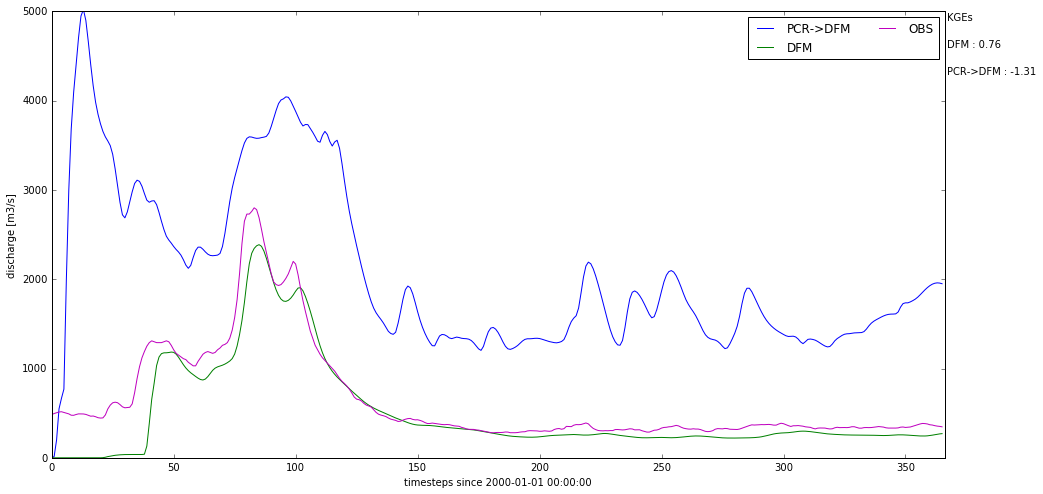

In [26]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
no_stA = Dataset(fo_stA, 'r')
#- extract simulated discharge from nc-file for DFM standalone
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_stA))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    
#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)

#- plot
plt.figure(figsize=(16,8))
plt.plot(qsim_ND, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4300, 'PCR->DFM : '+str(KGE_ND))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2DFM.png'), dpi=300)